# Ajinomoto Study - Pathway 2


In this notebook we demonstrate the use of the Automatic Recommendation Tool (ART) to recommend strain designs for improving dodecanol production using available data for Pathway 2 in Ajinomoto study. We first use cycle 1 data to provide recommendations and include cycle 2 data as test data points. Then, data from the two DBTL cycles jointly is used to provide recommendations for cycle 3.

First we import the package:

In [1]:
import sys
sys.path.append('../../')

import warning_utils
warning_utils.filter_end_user_warnings()

from IPython.display import HTML

from art import plot
from art.core import RecommendationEngine
from art.utility import load_study
from notebooks.paper import ajinomoto

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### First import the whole study and preprocess the data ###


In [2]:
# Strongly recommended workflow is to *greatly* reduce preprocessing work by loading
# standardized data from the  Experiment Data Depot (EDD, https://pubs.acs.org/doi/10.1021/acssynbio.7b00204).
# To skip the EDD registration step for new ART users & support automated notebook testing,
# load a data file downloaded from EDD instead.
load_from_edd = False

if load_from_edd:
    # Load data from EDD:
    #   * Bespoke data formats from well-meaning collaborators explode in complexity very quickly.
    #   * "Slug" is the final URL portion.  For this study, full URL is https://public-edd.jbei.org/s/ajinomoto/
    edd_study_slug = 'ajinomoto'
    edd_server = 'public-edd.jbei.org'
    df_edd = load_study(edd_study_slug=edd_study_slug,edd_server=edd_server, default_to_system_user=False)
else:
    df_edd = load_study(data_file= '../../data/Ajinomoto.csv')

Preprocessing includes: removing non relevant strains (C0 '9017', 'IPTG' and 'del') from the data set;
adding Cycle number, Strain number, Batch number, Replicate number and Pathway number columns in the dataframe;
combining all replicates and calculating mean and standard deviation;
optimal plotting of gene expression levels ordered for increasing production.

In [3]:
ajinomoto_df, ajinomoto_mean_df = ajinomoto.preprocess(df_edd, plot_flag=False)


/code/notebooks/paper/../../notebooks/paper/ajinomoto.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ajinomoto_df["Pathway"].loc[
/code/notebooks/paper/../../notebooks/paper/ajinomoto.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ajinomoto_df["Pathway"].loc[
/code/notebooks/paper/../../notebooks/paper/ajinomoto.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ajinomoto_df["Pathway"].loc[
/code/notebooks/paper/../../not

In [4]:
ajinomoto_df.head()

Line Name Measurement Type    Value  Cycle  Design  Batch  Replicate  \
0  C1_S1_B1.1-R1     dodecan-1-ol  0.72127      1       1      1          1   
1  C1_S1_B1.1-R1   hexadecan-1-ol  0.03371      1       1      1          1   
2  C1_S1_B1.1-R1   octadecan-1-ol  0.07051      1       1      1          1   
3  C1_S1_B1.1-R1  tetradecan-1-ol  0.05971      1       1      1          1   
4  C1_S1_B1.1-R2     dodecan-1-ol  0.65691      1       1      1          2   

   Pathway  
0        1  
1        1  
2        1  
3        1  
4        1

In [5]:
ajinomoto_mean_df.head()

Measurement Type  A1U2T0         A1U3L3  AHR_ECOLI  \
Design                                               
1                 1400.4  136244.400000      252.6   
2                  466.4  151604.200000      469.8   
3                  964.0  131395.333333     1660.0   
4                  931.0  572420.000000      358.5   
5                    0.0  447718.000000      891.0   

Measurement Type  Dodecanoyl-[acyl-carrier-protein] hydrolase, chloroplastic  \
Design                                                                         
1                                                     141483.000000            
2                                                     145170.600000            
3                                                     127283.666667            
4                                                     115678.500000            
5                                                     108267.000000            

Measurement Type  Fatty acyl-CoA reductase     LCFA_ECOLI  dodecan-1-ol  
Design                                                                   
1                               661.200000   98879.400000      0.655988  
2                                79.200000  113269.000000      0.606746  
3                                80.666667  353878.333333      0.168947  
4                               676.000000   81778.000000      0.468715  
5                                 0.000000   85735.333333      0.539463

### Proceed with the task of maximazing dodecanol production ###

Define ART input parameters:

In [6]:
art_params = {
    'input_vars': [
        'Dodecanoyl-[acyl-carrier-protein] hydrolase, chloroplastic',
        'LCFA_ECOLI',
        'A1U2T0'
    ],
    'response_vars': ['dodecan-1-ol'],
    'objective': 'maximize',
    'threshold': 0.2,
    'verbose': 1,
    'seed': 10,
    'output_dir': '../../results/Dodecanol_P2',
    'cross_val': True,
    'recommend': False,
    'num_recommendations': 10,
    'build_model': False,
    'max_mcmc_cores': 2,
}

In [7]:
# Set Pathway Variant
pathway_variant = 2

df = ajinomoto_df[['Line Name','Measurement Type','Value']].loc[ajinomoto_df['Pathway']==pathway_variant]

# Create Report Heading
title = '<h2>Pathway Maqu_2220 Titer Maximization.<br/>Recommendations for protein expressions provided.</h2>'
display(HTML(title))

Define training (Cycle 1) and test (Cycle 2) samples.

In [8]:
df_1 = df[df['Line Name'].str.contains('C1')]
df_2 = df[df['Line Name'].str.contains('C2')]

In [9]:
art_C1 = RecommendationEngine(df=df_1,**art_params)
art_test = RecommendationEngine(df=df_2,**art_params)

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.
Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 11 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
ART identified 10 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.


How many instances/replicates?

In [10]:
print(f'Cycle 1: {len(art_C1.df)}\nCycle 2: {len(art_test.df)}')


Cycle 1: 31
Cycle 2: 30


How manu unique designs/strains?

In [11]:
lines1 = [line.split('_')[1] for line in art_C1.df.index]
lines2 = [line.split('_')[1] for line in art_test.df.index]
print(f'Cycle 1: {len(set(lines1))}\nCycle 2: {len(set(lines2))}')


Cycle 1: 9
Cycle 2: 10


How many replicates resulted in no product detected?

In [12]:
product = art_C1.df['Response Variables','dodecan-1-ol']
zero_product1 = product[product==0]
product = art_test.df['Response Variables','dodecan-1-ol']
zero_product2 = product[product==0]
print(f'Cycle 1: {len(zero_product1)}\nCycle 2: {len(zero_product2)}')


Cycle 1: 10
Cycle 2: 14


How many strains resulted in no product detected?

In [13]:
lines1 = [line.split('_')[1] for line in zero_product1.index]
lines2 = [line.split('_')[1] for line in zero_product2.index]
print(f'Cycle 1: {len(set(lines1))}\nCycle 2: {len(set(lines2))}')


Cycle 1: 4
Cycle 2: 5


## DBTL Cycle 1 ##

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 11 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(SelectPercentile(RBFSampler(Normalizer(input_matrix, norm=max), gamma=0.9), percentile=28), learning_rate=0.01, loss=square, n_estimators=100)
Done fitting L0 models in 91.11 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 28.47 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(FastICA(Normalizer(input_matrix, norm=l2), tol=0.9), learning_rate=0.001, loss=square, n_estimators=100)
Done fitting L0 models in 106.33 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 26.21 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(OneHotEncoder(input_matrix, minimum_fraction=0.15, sparse=False, threshold=10), learning_rate=0.001, loss=square, n_estimators=100)
Done fitting L0 models in 2.77 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 20.98 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(DecisionTreeRegressor(input_matrix, max_depth=5, min_samples_leaf=15, min_samples_split=15), learning_rate=0.01, loss=square, n_estimators=100)
Done fitting L0 models in 50.87 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 22.77 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(RidgeCV(PCA(input_matrix, iterated_power=3, svd_solver=randomized)), learning_rate=0.1, loss=linear, n_estimators=100)
Done fitting L0 models in 59.98 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 29.61 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(RidgeCV(input_matrix), learning_rate=0.5, loss=square, n_estimators=100)
Done fitting L0 models in 3.22 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 22.54 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(Normalizer(input_matrix, norm=l2), learning_rate=0.001, loss=exponential, n_estimators=100)
Done fitting L0 models in 2.70 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 25.37 s
Fitting L0 models…
Building TPOT models…
Best pipeline: DecisionTreeRegressor(SelectFromModel(Normalizer(input_matrix, norm=l1), max_features=0.4, n_estimators=100, threshold=0.15000000000000002), max_depth=10, min_samples_leaf=2, min_samples_split=9)
Done fitting L0 models in 31.86 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 24.69 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(PolynomialFeatures(SGDRegressor(SelectPercentile(ZeroCount(LassoLarsCV(input_matrix, normalize=False)), percentile=36), alpha=0.01, eta0=0.01, fit_intercept=True, l1_ratio=0.5, learning_rate=constant, loss=huber, penalty=elasticnet, power_t=0.1), degree=2, include_bias=False, interaction_only=False), learning_rate=0.5, loss=exponential, n_estimators=100)
Done fitting L0 models in 72.09 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 34 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 35.58 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(MaxAbsScaler(input_matrix), learning_rate=0.1, loss=exponential, n_estimators=100)
Done fitting L0 models in 4.32 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 15.10 s


/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])
/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: invalid value encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.081794      inf  0.090421  0.014866 -2.290913
Random Forest Regressor      0.016785      inf  0.007225  0.000334  0.926080
Support Vector Regressor     0.066005      inf  0.013834  0.004548 -0.006779
Kernel Ridge Regressor       0.031515      inf  0.034577  0.002189  0.515484
K-NN Regressor               0.031887      inf  0.034493  0.002207  0.511542
Gaussian Process Regressor   0.049415      inf  0.036950  0.003807  0.157222
Gradient Boosting Regressor  0.019095      inf  0.009802  0.000461  0.898018
TPOT Regressor               0.016243      NaN  0.008099  0.000329  0.927077
Ensemble Model               0.020778      inf  0.009910  0.000530  0.882690

Done with 10-fold cross-validation in 689.07 s


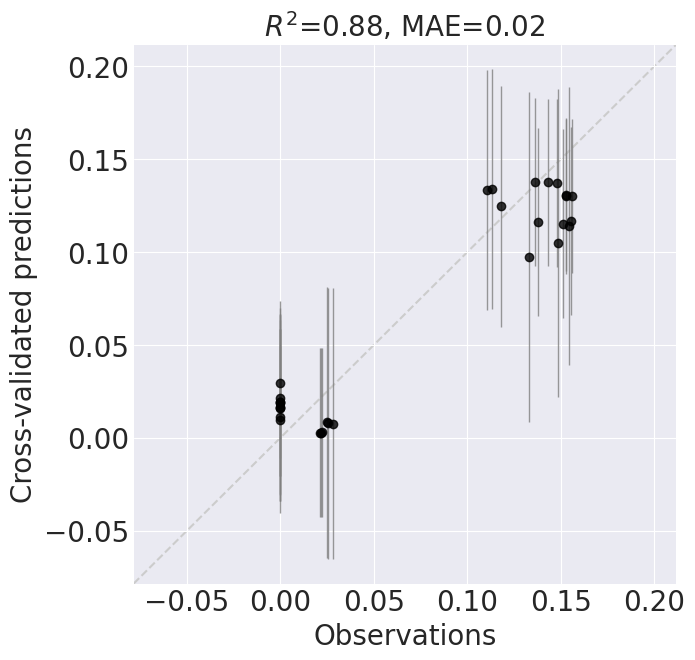

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RandomForestRegressor(SelectPercentile(input_matrix, percentile=39), bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=1, min_samples_split=14, n_estimators=100)
Done fitting L0 models in 50.37 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 27.34 s


/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])
/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: invalid value encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE           MSE  \
Name                                                                     
Neural Regressor             0.036725      inf  0.020716  1.777892e-03   
Random Forest Regressor      0.003083      inf  0.002070  1.378771e-05   
Support Vector Regressor     0.065983      inf  0.013819  4.544743e-03   
Kernel Ridge Regressor       0.013711      inf  0.014353  3.939979e-04   
K-NN Regressor               0.013248      NaN  0.015973  4.306248e-04   
Gaussian Process Regressor   0.000441      inf  0.000531  4.771925e-07   
Gradient Boosting Regressor  0.000304      inf  0.000224  1.423693e-07   
TPOT Regressor               0.009808      NaN  0.006744  1.416696e-04   
Ensemble Model               0.008876      inf  0.004907  1.028643e-04   

                                $R^2$  
Name                                   
Neural Regressor             0.606431  
Random Forest Regressor      0.996948  
Support Vector Regressor    -0.006062  
Kernel Ridge Regressor       0.912781  
K-NN Regressor               0.904673  
Gaussian Process Regressor   0.999894  
Gradient Boosting Regressor  0.999968  
TPOT Regressor               0.968639  
Ensemble Model               0.977229

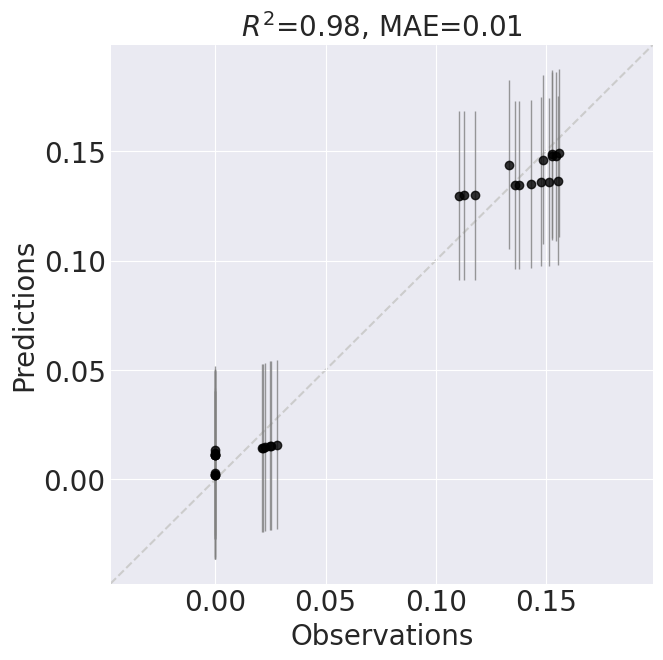

Done building models in 79.18 s
CPU times: user 7min 51s, sys: 6.18 s, total: 7min 57s
Wall time: 12min 48s


In [14]:
%%time
# Run ART
art_params['build_model'] = True
art_C1 = RecommendationEngine(df=df_1, result_suffix="_C1", **art_params)

In [15]:
art_C1.evaluate_models_cv()

MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.081794      inf  0.090421  0.014866 -2.290913
Random Forest Regressor      0.016785      inf  0.007225  0.000334  0.926080
Support Vector Regressor     0.066005      inf  0.013834  0.004548 -0.006779
Kernel Ridge Regressor       0.031515      inf  0.034577  0.002189  0.515484
K-NN Regressor               0.031887      inf  0.034493  0.002207  0.511542
Gaussian Process Regressor   0.049415      inf  0.036950  0.003807  0.157222
Gradient Boosting Regressor  0.019095      inf  0.009802  0.000461  0.898018
TPOT Regressor               0.016243      NaN  0.008099  0.000329  0.927077
Ensemble Model               0.020778      inf  0.009910  0.000530  0.882690

In [16]:
art_C1.evaluate_models(art_C1.X, art_C1.y)

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])
/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: invalid value encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE           MSE  \
Name                                                                     
Neural Regressor             0.036725      inf  0.020716  1.777892e-03   
Random Forest Regressor      0.003083      inf  0.002070  1.378771e-05   
Support Vector Regressor     0.065983      inf  0.013819  4.544743e-03   
Kernel Ridge Regressor       0.013711      inf  0.014353  3.939979e-04   
K-NN Regressor               0.013248      NaN  0.015973  4.306248e-04   
Gaussian Process Regressor   0.000441      inf  0.000531  4.771925e-07   
Gradient Boosting Regressor  0.000304      inf  0.000224  1.423693e-07   
TPOT Regressor               0.009808      NaN  0.006744  1.416696e-04   
Ensemble Model               0.008876      inf  0.004907  1.028643e-04   

                                $R^2$  
Name                                   
Neural Regressor             0.606431  
Random Forest Regressor      0.996948  
Support Vector Regressor    -0.006062  
Kernel Ridge Regressor       0.912781  
K-NN Regressor               0.904673  
Gaussian Process Regressor   0.999894  
Gradient Boosting Regressor  0.999968  
TPOT Regressor               0.968639  
Ensemble Model               0.977229

In [17]:
X_test = art_test.X
y_test = art_test.y
display(HTML('Evaluation of learned predictive models on test data:'))
art_C1.evaluate_models(X_test, y_test)

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])
/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: invalid value encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE       MSE      $R^2$
Name                                                                         
Neural Regressor             0.105203      inf  0.056227  0.014229 -26.862432
Random Forest Regressor      0.058906      inf  0.054930  0.006487 -11.702833
Support Vector Regressor     0.062591      inf  0.022598  0.004428  -7.671161
Kernel Ridge Regressor       0.023649      inf  0.013430  0.000740  -0.448345
K-NN Regressor               0.017065      NaN  0.022933  0.000817  -0.600053
Gaussian Process Regressor   0.026614      inf  0.017260  0.001006  -0.970307
Gradient Boosting Regressor  0.060155      inf  0.056690  0.006832 -12.378728
TPOT Regressor               0.064765      NaN  0.062789  0.008137 -14.933124
Ensemble Model               0.060784      inf  0.058022  0.007061 -12.826879

Plot observations vs. predictions distributions for the train and test data.

Use the ensemble model to predict Cycle 2 strain performance.

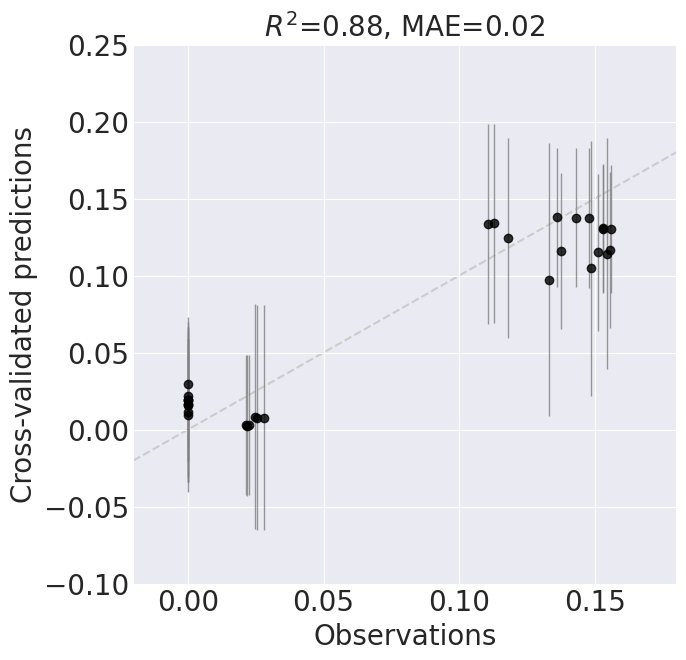

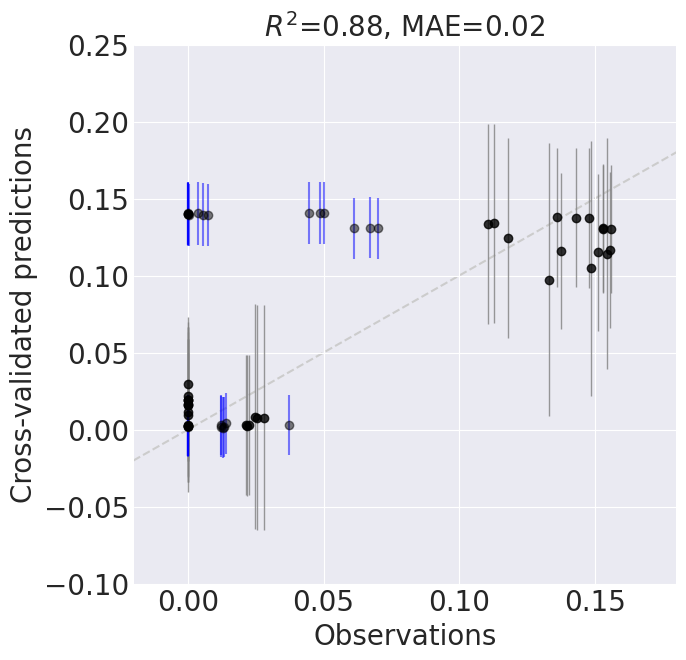

In [18]:
plot.predictions_vs_observations(art_C1, cv=True, error_bars=True,
                                 x_limits=[[-0.02, 0.18]], y_limits=[[-0.1, 0.25]])
plot.predictions_vs_observations(art_C1, cv=True, error_bars=True, X_test=X_test, y_test=y_test,
                                 x_limits=[[-0.02, 0.18]], y_limits=[[-0.1, 0.25]])


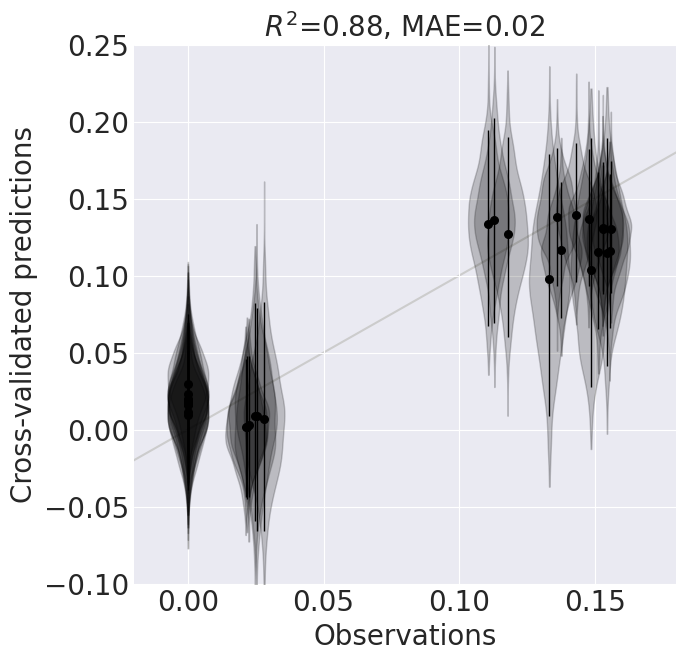

Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.73 s


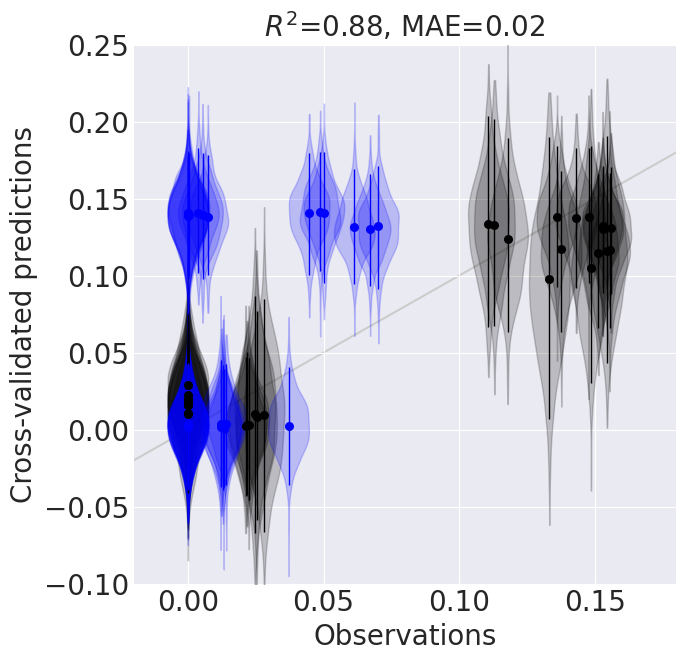

In [19]:
plot.predictions_distr_vs_observations(art_C1, widths=0.015,
                                       x_limits=[[-0.02, 0.18]], y_limits=[[-0.1, 0.25]], log=False)
plot.predictions_distr_vs_observations(art_C1, widths=0.015, X_test=X_test, y_test=y_test,
                                         x_limits=[[-0.02, 0.18]], y_limits=[[-0.1, 0.25]],log=False)

Perform sampling-based optimization using the ensemble model

In [20]:
%%time
draws = art_C1.generate_recommendation_candidates()

Starting parallel tempering using 2 chains…
Done with parallel tempering in 236.59 s
CPU times: user 49.7 ms, sys: 11.3 ms, total: 61 ms
Wall time: 3min 56s


Choosing recommendations (19,800 candidates)…


Done choosing recommendations in 0.04 s


Dodecanoyl-[acyl-carrier-protein] hydrolase, chloroplastic     LCFA_ECOLI  \
0                                      114531.725941           335574.522398   
1                                      110216.575769           266569.964540   
2                                       77234.803838           217805.148300   
3                                       63531.239478           271296.178500   
4                                       69889.407603           265496.750246   
5                                      106531.772759           328224.996398   
6                                       98154.023423           212659.772178   
7                                      113517.459155           404134.085385   
8                                      138730.822582           336102.496495   
9                                       65886.385813           333189.317643   

          A1U2T0  dodecan-1-ol  
0  226658.277864      0.148698  
1  204342.092656      0.148531  
2  211912.936413      0.148221  
3  215386.138546      0.148060  
4  169044.252166      0.147867  
5  170481.014578      0.147672  
6  223785.197041      0.147665  
7  225481.930434      0.147427  
8  215523.234460      0.147396  
9  226482.125324      0.147394

Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.72 s


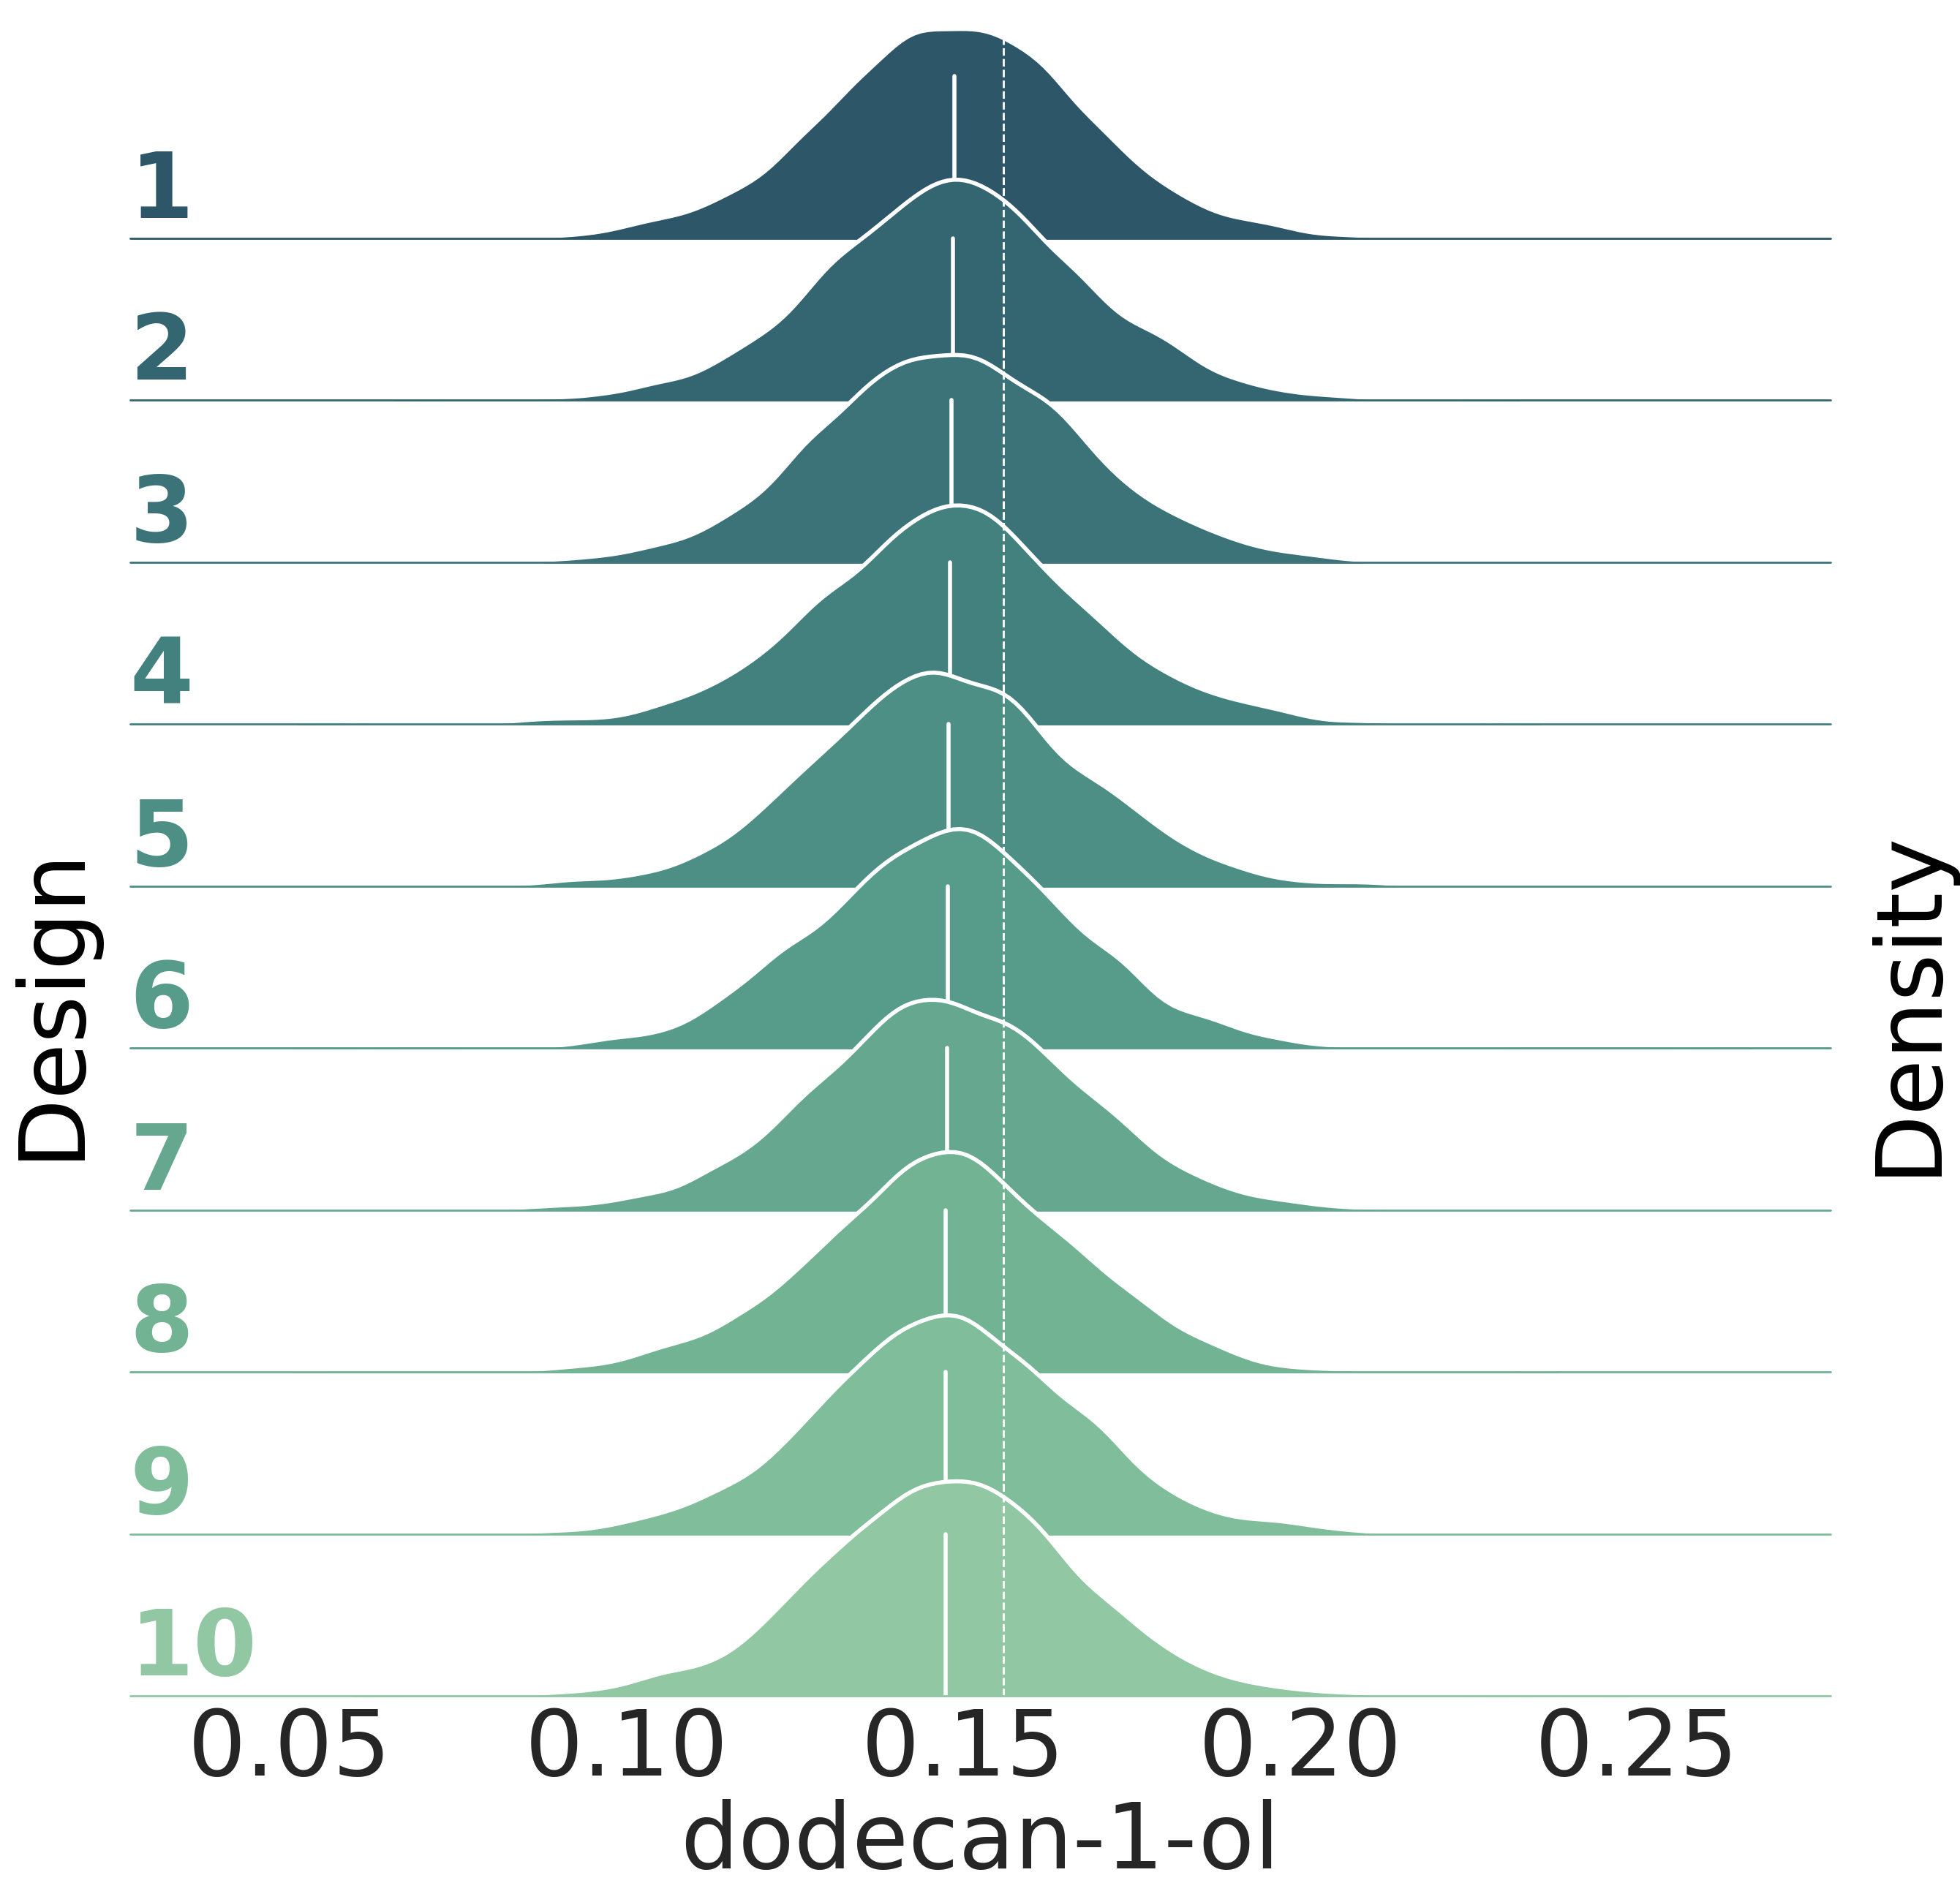

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.73 s
Done computing success probabilities in 0.73 s


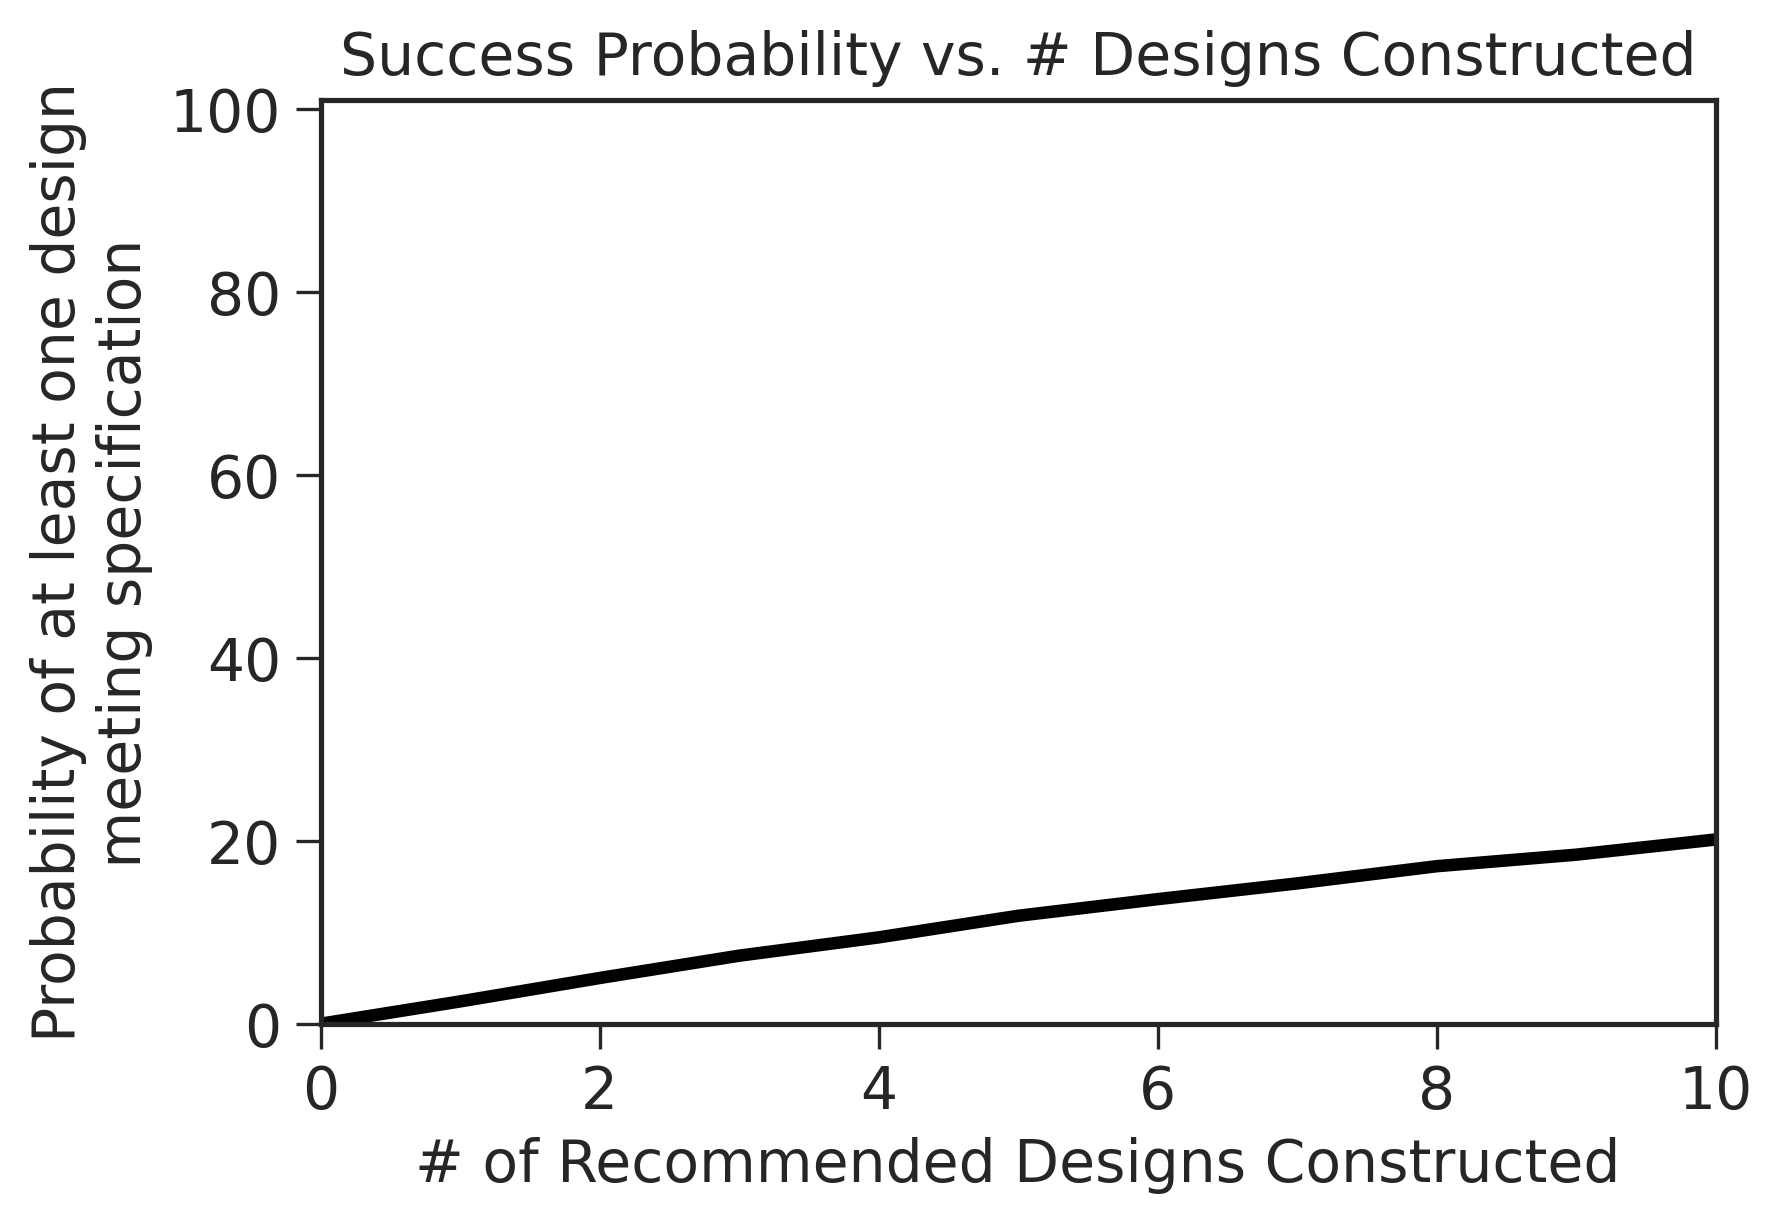

In [21]:
art_C1.select_recommendations(draws)

Visualize the predicted dodecanol mean production levels (solid lines) and the associated uncertainty (distributions).
Dashed lines show production levels for the test data points.

Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.72 s


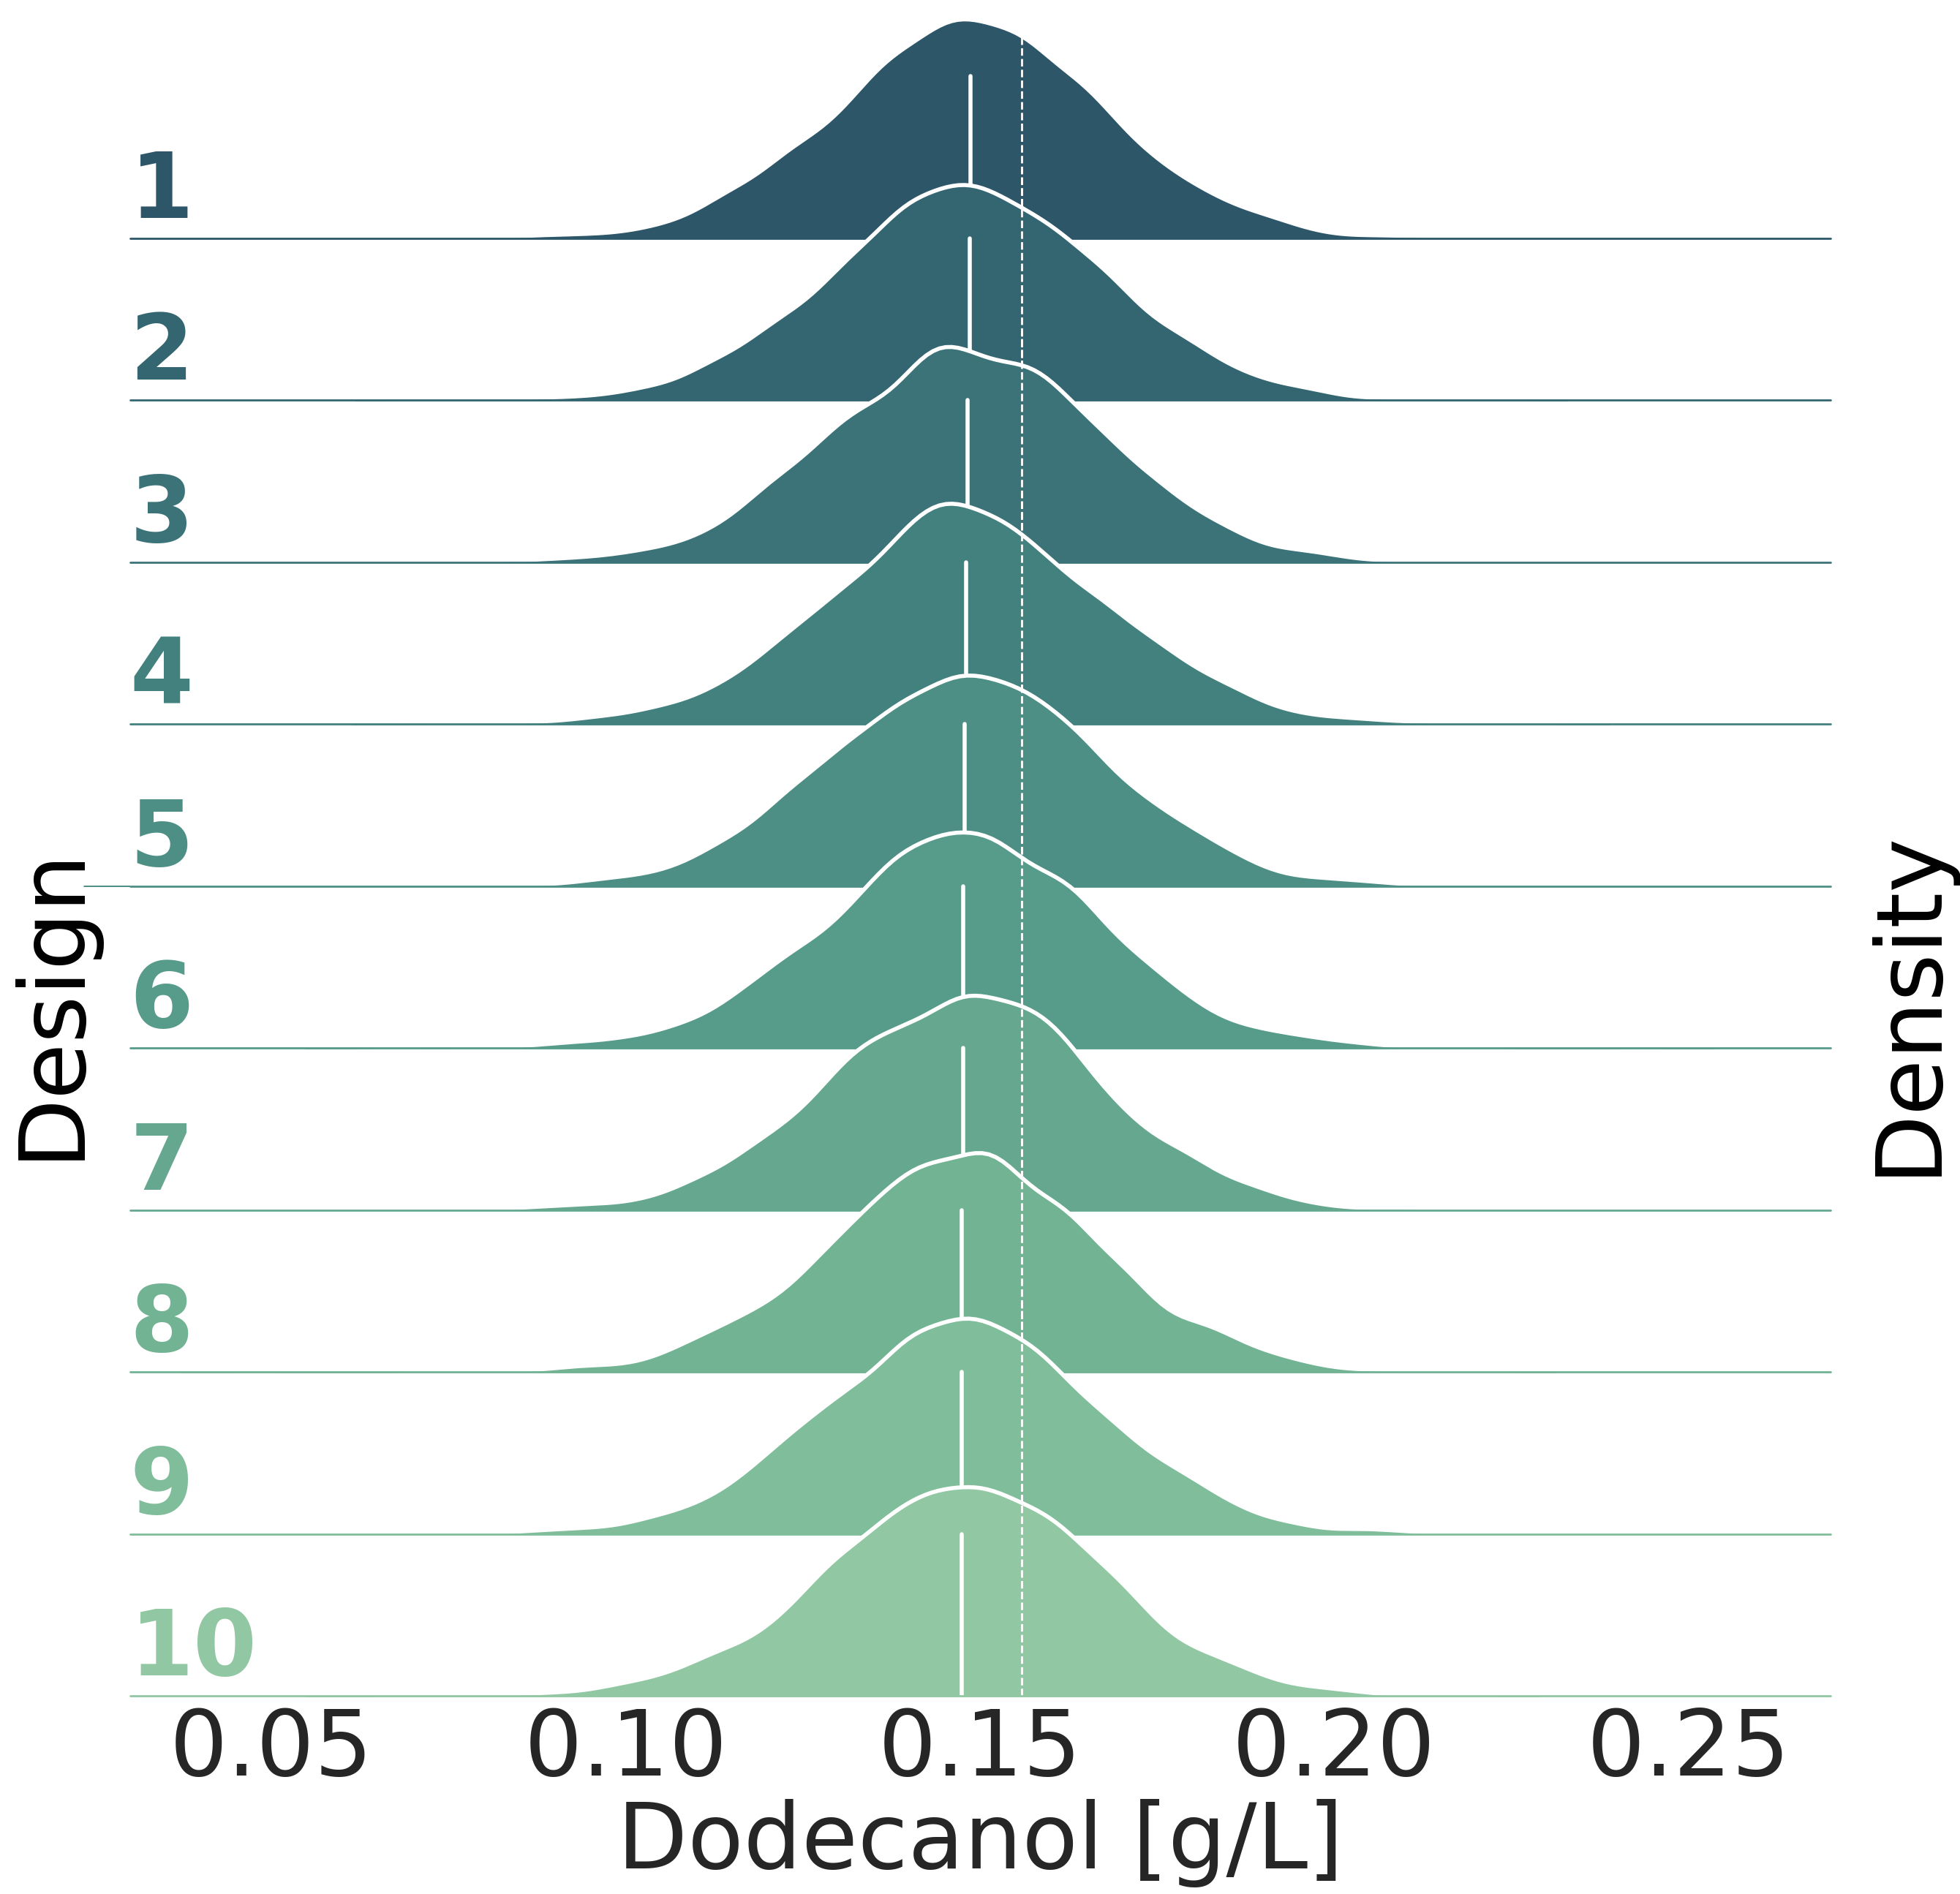

In [22]:
name = ['Dodecanol [g/L]']
plot.recomm_distribution(art_C1, name,[0.03,0.27])

Plot probability of success

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.72 s
Done computing success probabilities in 0.72 s


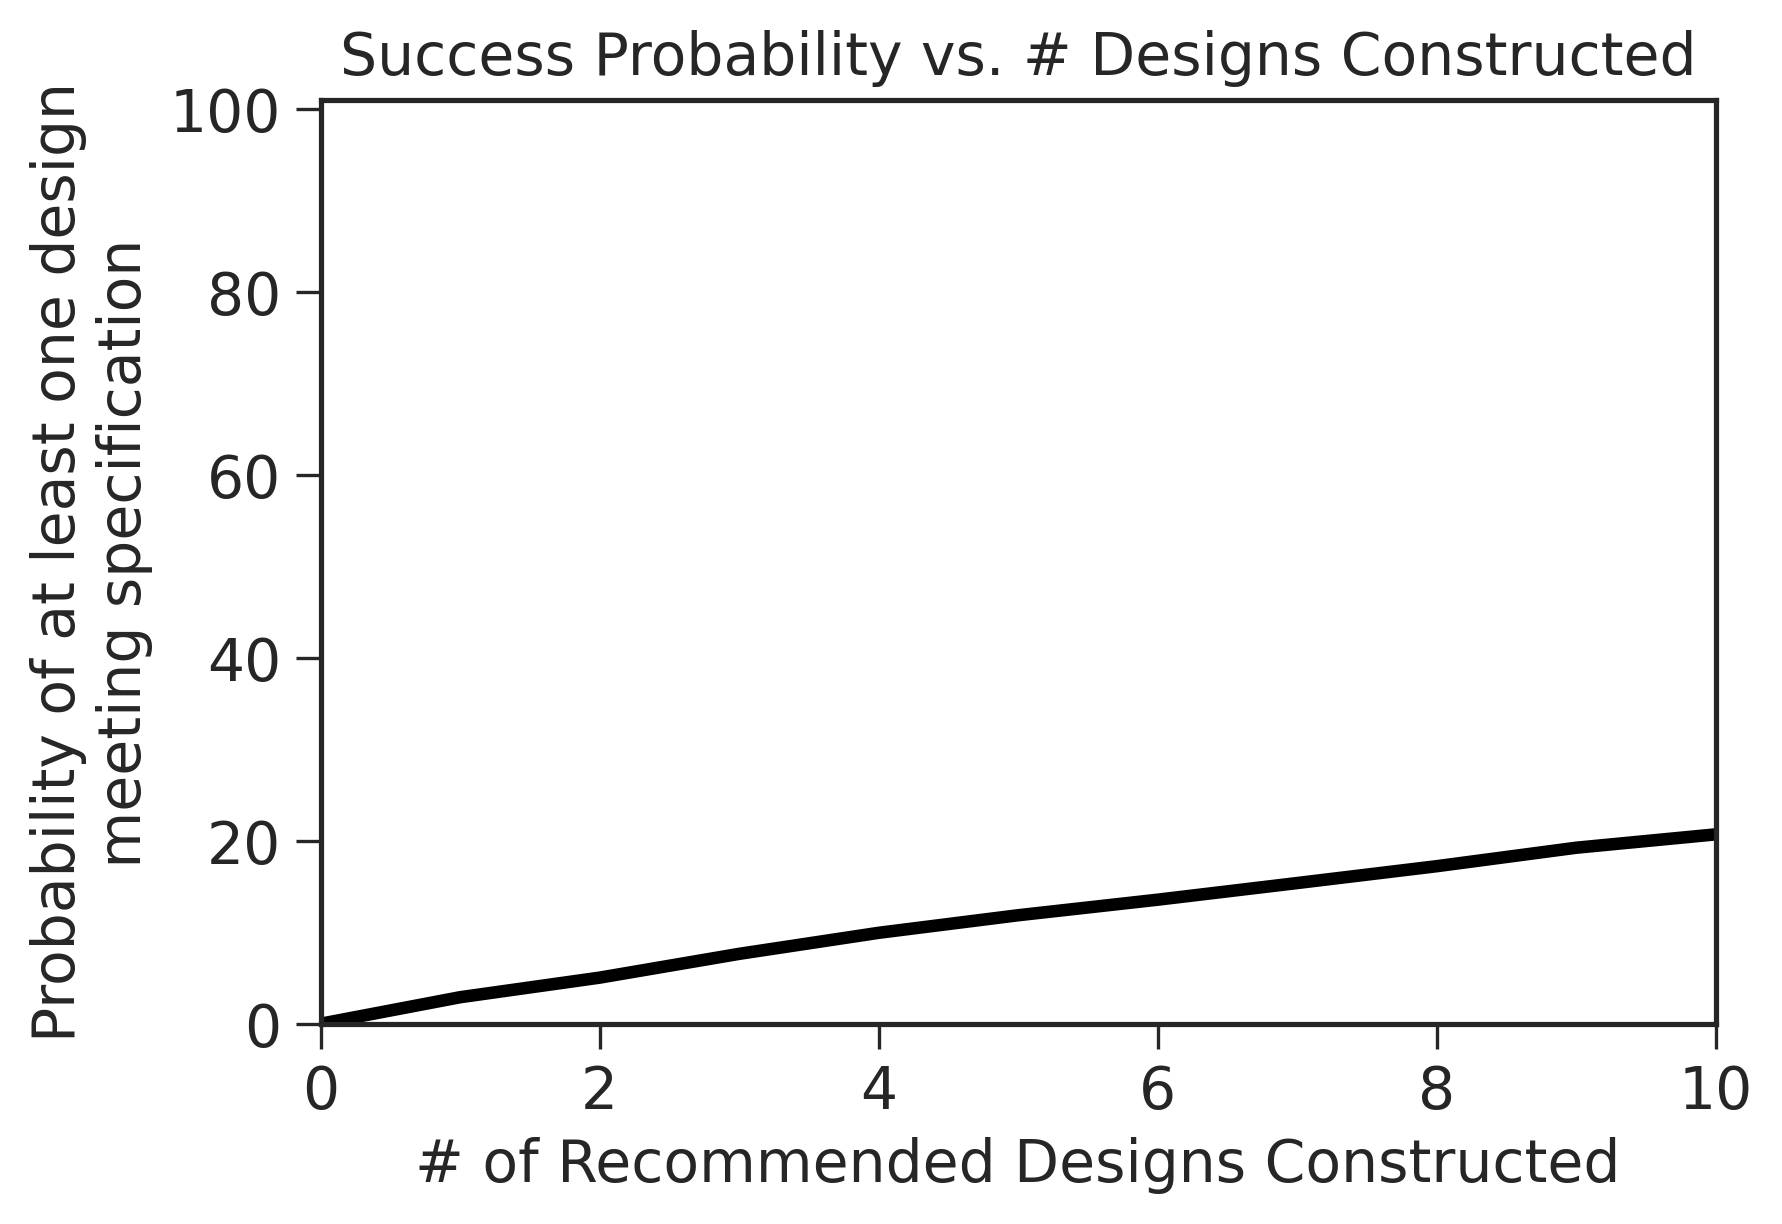

In [23]:
cum_success_prob = art_C1.compute_success_prob(current_best=art_C1.find_current_best())
plot.success_prob(art_C1, cum_success_prob)

Visualize the first two principal components of draws from the samapling phase and show train, i.e. Cycle 1 data (in red).

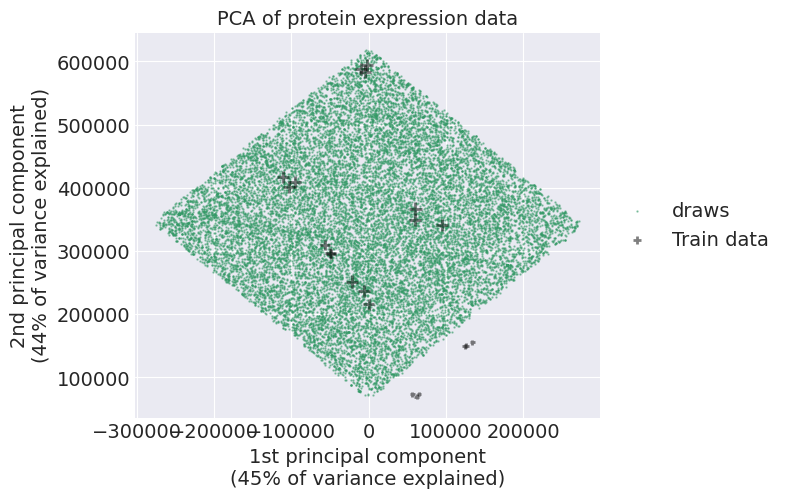

In [24]:
plot.draws_pc(art_C1, draws, plot_scale_factor=500, plot_draws=True, plot_kde=False)

Visualize the first two principal components of the recommendations and train (cycle 1) and test (Cycle 2) data

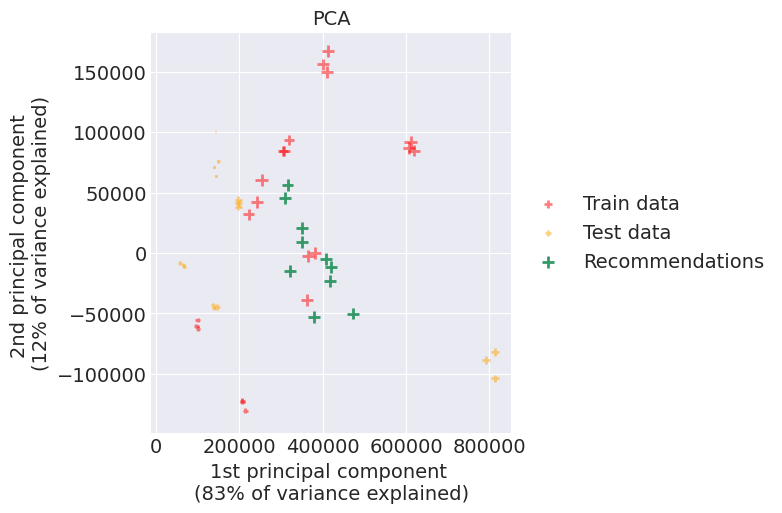

In [25]:
plot.recommendations_pc(art_C1, plot_scale_factor=500, X_test=X_test, label_test='Test data', objective_value_y_test=y_test)

In [26]:
art_C1.save()

Perform sampling-based optimization using the ensemble model

### Recommend strains for the next DBTL cycle ###

Repeat the process by including data from both cycles.

Define new training set with all available data.

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


ART identified 21 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…
Best pipeline: DecisionTreeRegressor(Normalizer(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), norm=l2), max_depth=1, min_samples_leaf=13, min_samples_split=19)
Done fitting L0 models in 17.91 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 34.89 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LinearSVR(AdaBoostRegressor(RBFSampler(FastICA(input_matrix, tol=0.75), gamma=0.6000000000000001), learning_rate=1.0, loss=linear, n_estimators=100), C=10.0, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=0.0001)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done fitting L0 models in 36.13 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 24.44 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(PCA(StandardScaler(input_matrix), iterated_power=2, svd_solver=randomized), learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.8, verbosity=0)
Done fitting L0 models in 4.54 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 16.93 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(LinearSVR(input_matrix, C=25.0, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=0.1), learning_rate=0.001, loss=exponential, n_estimators=100)
Done fitting L0 models in 3.98 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 15.49 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(Nystroem(Normalizer(LassoLarsCV(input_matrix, normalize=False), norm=l1), gamma=0.25, kernel=rbf, n_components=7), normalize=True)
Done fitting L0 models in 59.53 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 27.18 s
Fitting L0 models…
Building TPOT models…
Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.99, learning_rate=1.0, loss=huber, max_depth=9, max_features=0.7500000000000001, min_samples_leaf=6, min_samples_split=4, n_estimators=100, subsample=0.9000000000000001)
Done fitting L0 models in 65.47 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 14.74 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(LassoLarsCV(RidgeCV(input_matrix), normalize=True), learning_rate=0.5, loss=square, n_estimators=100)
Done fitting L0 models in 41.85 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 24.62 s
Fitting L0 models…
Building TPOT models…
Best pipeline: LassoLarsCV(PolynomialFeatures(ElasticNetCV(input_matrix, l1_ratio=0.35000000000000003, tol=0.1), degree=2, include_bias=False, interaction_only=False), normalize=False)
Done fitting L0 models in 48.80 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=2.001e-03, previous alpha=1.372e-07, with an active set of 10 regressors.
  warnings.warn(


Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 51 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 52.25 s
Fitting L0 models…
Building TPOT models…
Best pipeline: DecisionTreeRegressor(XGBRegressor(input_matrix, learning_rate=0.5, max_depth=8, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.2, verbosity=0), max_depth=4, min_samples_leaf=10, min_samples_split=11)
Done fitting L0 models in 4.11 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 25.52 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(SGDRegressor(RidgeCV(Normalizer(input_matrix, norm=max)), alpha=0.001, eta0=1.0, fit_intercept=True, l1_ratio=0.25, learning_rate=constant, loss=huber, penalty=elasticnet, power_t=0.5), learning_rate=1.0, loss=square, n_estimators=100)
Done fitting L0 models in 49.26 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 27.94 s


/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])
/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: invalid value encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.071736      inf  0.069939  0.010038 -1.979288
Random Forest Regressor      0.029173      NaN  0.032568  0.001912  0.432571
Support Vector Regressor     0.064315      inf  0.018764  0.004488 -0.332235
Kernel Ridge Regressor       0.018244      inf  0.019271  0.000704  0.790977
K-NN Regressor               0.022587      NaN  0.020197  0.000918  0.727503
Gaussian Process Regressor   0.024179      inf  0.029205  0.001438  0.573308
Gradient Boosting Regressor  0.030253      inf  0.031782  0.001925  0.428542
TPOT Regressor               0.036626      inf  0.035719  0.002617  0.223140
Ensemble Model               0.026953      inf  0.029322  0.001586  0.529188

Done with 10-fold cross-validation in 608.60 s


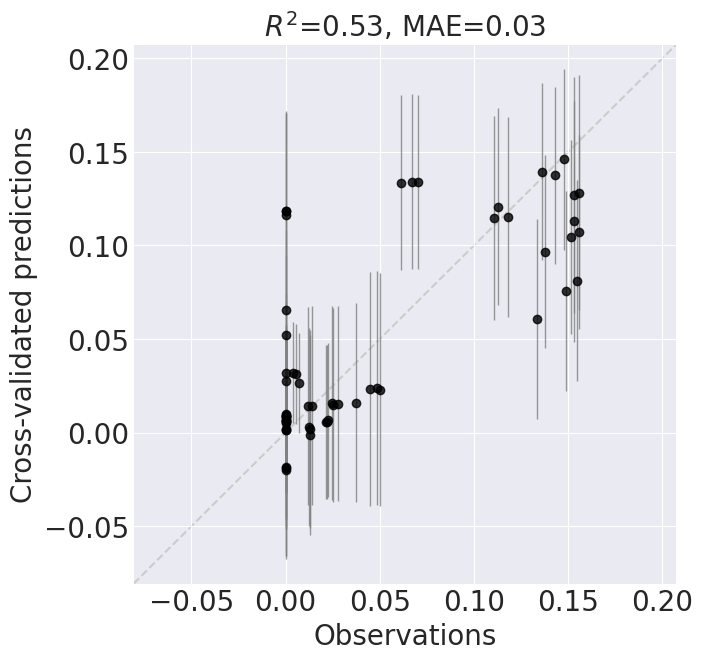

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=4, p=1, weights=distance)
Done fitting L0 models in 3.65 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 19.21 s


/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])
/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: invalid value encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE           MSE  \
Name                                                                     
Neural Regressor             0.047988      inf  0.047593  4.567967e-03   
Random Forest Regressor      0.004343      NaN  0.007402  7.366046e-05   
Support Vector Regressor     0.064315      inf  0.018737  4.487467e-03   
Kernel Ridge Regressor       0.012322      inf  0.013122  3.240322e-04   
K-NN Regressor               0.007899      NaN  0.008735  1.386911e-04   
Gaussian Process Regressor   0.002725      inf  0.002841  1.549594e-05   
Gradient Boosting Regressor  0.000747      inf  0.000597  9.138043e-07   
TPOT Regressor               0.000000      NaN  0.000000  0.000000e+00   
Ensemble Model               0.008965      inf  0.007265  1.331600e-04   

                                $R^2$  
Name                                   
Neural Regressor            -0.355832  
Random Forest Regressor      0.978137  
Support Vector Regressor    -0.331939  
Kernel Ridge Regressor       0.903823  
K-NN Regressor               0.958835  
Gaussian Process Regressor   0.995401  
Gradient Boosting Regressor  0.999729  
TPOT Regressor               1.000000  
Ensemble Model               0.960476

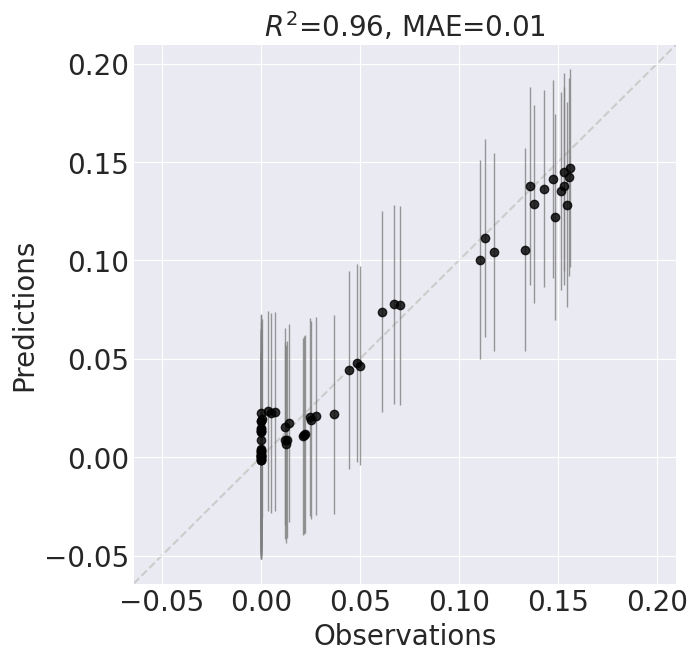

Done building models in 24.20 s


In [27]:
art_C2 = RecommendationEngine(df=df, result_suffix="_C2", **art_params)


In [28]:
art_C2.evaluate_models()

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])
/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: invalid value encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


MAE  MRAE(%)     StdAE           MSE  \
Name                                                                     
Neural Regressor             0.047988      inf  0.047593  4.567967e-03   
Random Forest Regressor      0.004343      NaN  0.007402  7.366046e-05   
Support Vector Regressor     0.064315      inf  0.018737  4.487467e-03   
Kernel Ridge Regressor       0.012322      inf  0.013122  3.240322e-04   
K-NN Regressor               0.007899      NaN  0.008735  1.386911e-04   
Gaussian Process Regressor   0.002725      inf  0.002841  1.549594e-05   
Gradient Boosting Regressor  0.000747      inf  0.000597  9.138043e-07   
TPOT Regressor               0.000000      NaN  0.000000  0.000000e+00   
Ensemble Model               0.008965      inf  0.007265  1.331600e-04   

                                $R^2$  
Name                                   
Neural Regressor            -0.355832  
Random Forest Regressor      0.978137  
Support Vector Regressor    -0.331939  
Kernel Ridge Regressor       0.903823  
K-NN Regressor               0.958835  
Gaussian Process Regressor   0.995401  
Gradient Boosting Regressor  0.999729  
TPOT Regressor               1.000000  
Ensemble Model               0.960476

In [29]:
art_C2.evaluate_models_cv()

MAE  MRAE(%)     StdAE       MSE     $R^2$
Name                                                                        
Neural Regressor             0.071736      inf  0.069939  0.010038 -1.979288
Random Forest Regressor      0.029173      NaN  0.032568  0.001912  0.432571
Support Vector Regressor     0.064315      inf  0.018764  0.004488 -0.332235
Kernel Ridge Regressor       0.018244      inf  0.019271  0.000704  0.790977
K-NN Regressor               0.022587      NaN  0.020197  0.000918  0.727503
Gaussian Process Regressor   0.024179      inf  0.029205  0.001438  0.573308
Gradient Boosting Regressor  0.030253      inf  0.031782  0.001925  0.428542
TPOT Regressor               0.036626      inf  0.035719  0.002617  0.223140
Ensemble Model               0.026953      inf  0.029322  0.001586  0.529188

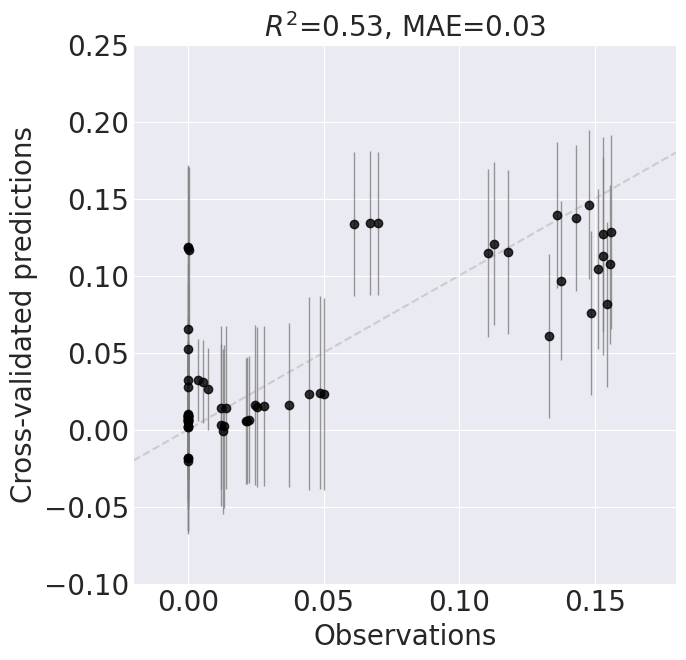

In [30]:
plot.predictions_vs_observations(art_C2, cv=True, error_bars=True,
                                 x_limits=[[-0.02, 0.18]], y_limits=[[-0.1, 0.25]])

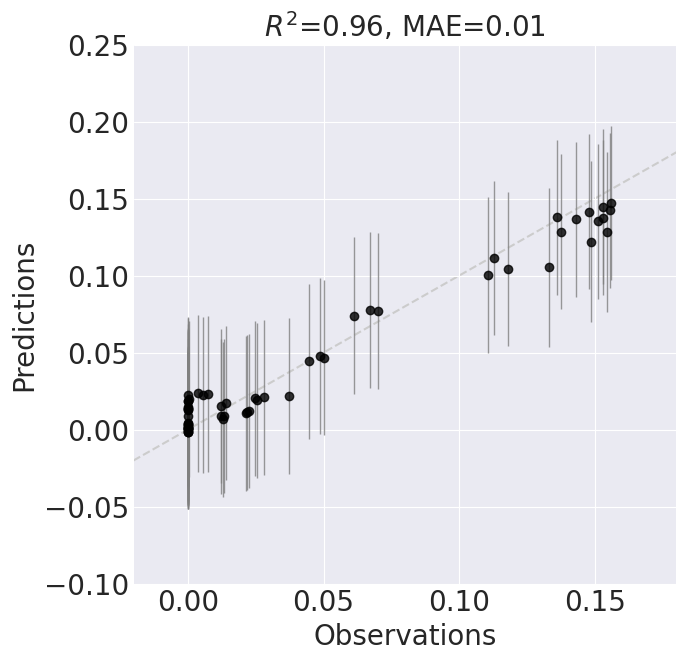

In [31]:
plot.predictions_vs_observations(art_C2, cv=False, error_bars=True,
                                 x_limits=[[-0.02, 0.18]], y_limits=[[-0.1, 0.25]])

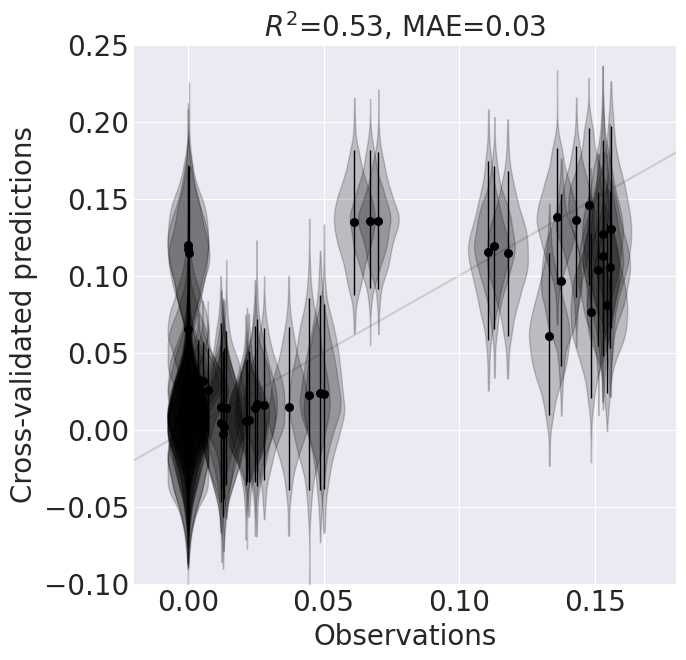

In [32]:
plot.predictions_distr_vs_observations(art_C2, widths=0.015, x_limits=[[-0.02, 0.18]], y_limits=[[-0.1, 0.25]])

Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.71 s


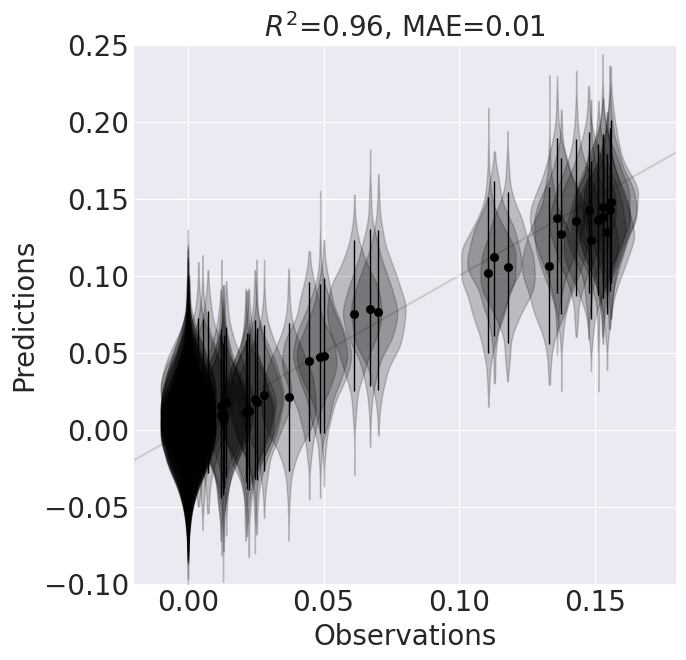

In [33]:
plot.predictions_distr_vs_observations(art_C2, cv=False, widths=0.02,
                                 x_limits=[[-0.02, 0.18]], y_limits=[[-0.1, 0.25]])

In [34]:
%%time
draws_2 = art_C2.generate_recommendation_candidates()

Starting parallel tempering using 2 chains…
Done with parallel tempering in 113.07 s
CPU times: user 39.6 ms, sys: 3.15 ms, total: 42.7 ms
Wall time: 1min 53s


Choosing recommendations (19,800 candidates)…


Done choosing recommendations in 0.15 s


Dodecanoyl-[acyl-carrier-protein] hydrolase, chloroplastic     LCFA_ECOLI  \
0                                      167874.748146           344579.095199   
1                                      179127.998863           363220.572639   
2                                      117568.061379           300461.479025   
3                                      159485.193855           270561.673913   
4                                      140405.799543           361667.153376   
5                                      112102.818589           298716.769897   
6                                      163229.891497           415489.726464   
7                                       88382.170831           246623.899327   
8                                       87016.725051           302808.606014   
9                                      147059.175704           275124.062528   

          A1U2T0  dodecan-1-ol  
0  391156.141215      0.157361  
1  308965.045802      0.152870  
2  307319.710531      0.152756  
3  422249.973032      0.152220  
4  298385.795011      0.151784  
5  368861.320077      0.151669  
6  373710.204036      0.150411  
7  323405.545135      0.150323  
8  287327.907029      0.149789  
9  334014.571325      0.148804

Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 0.69 s


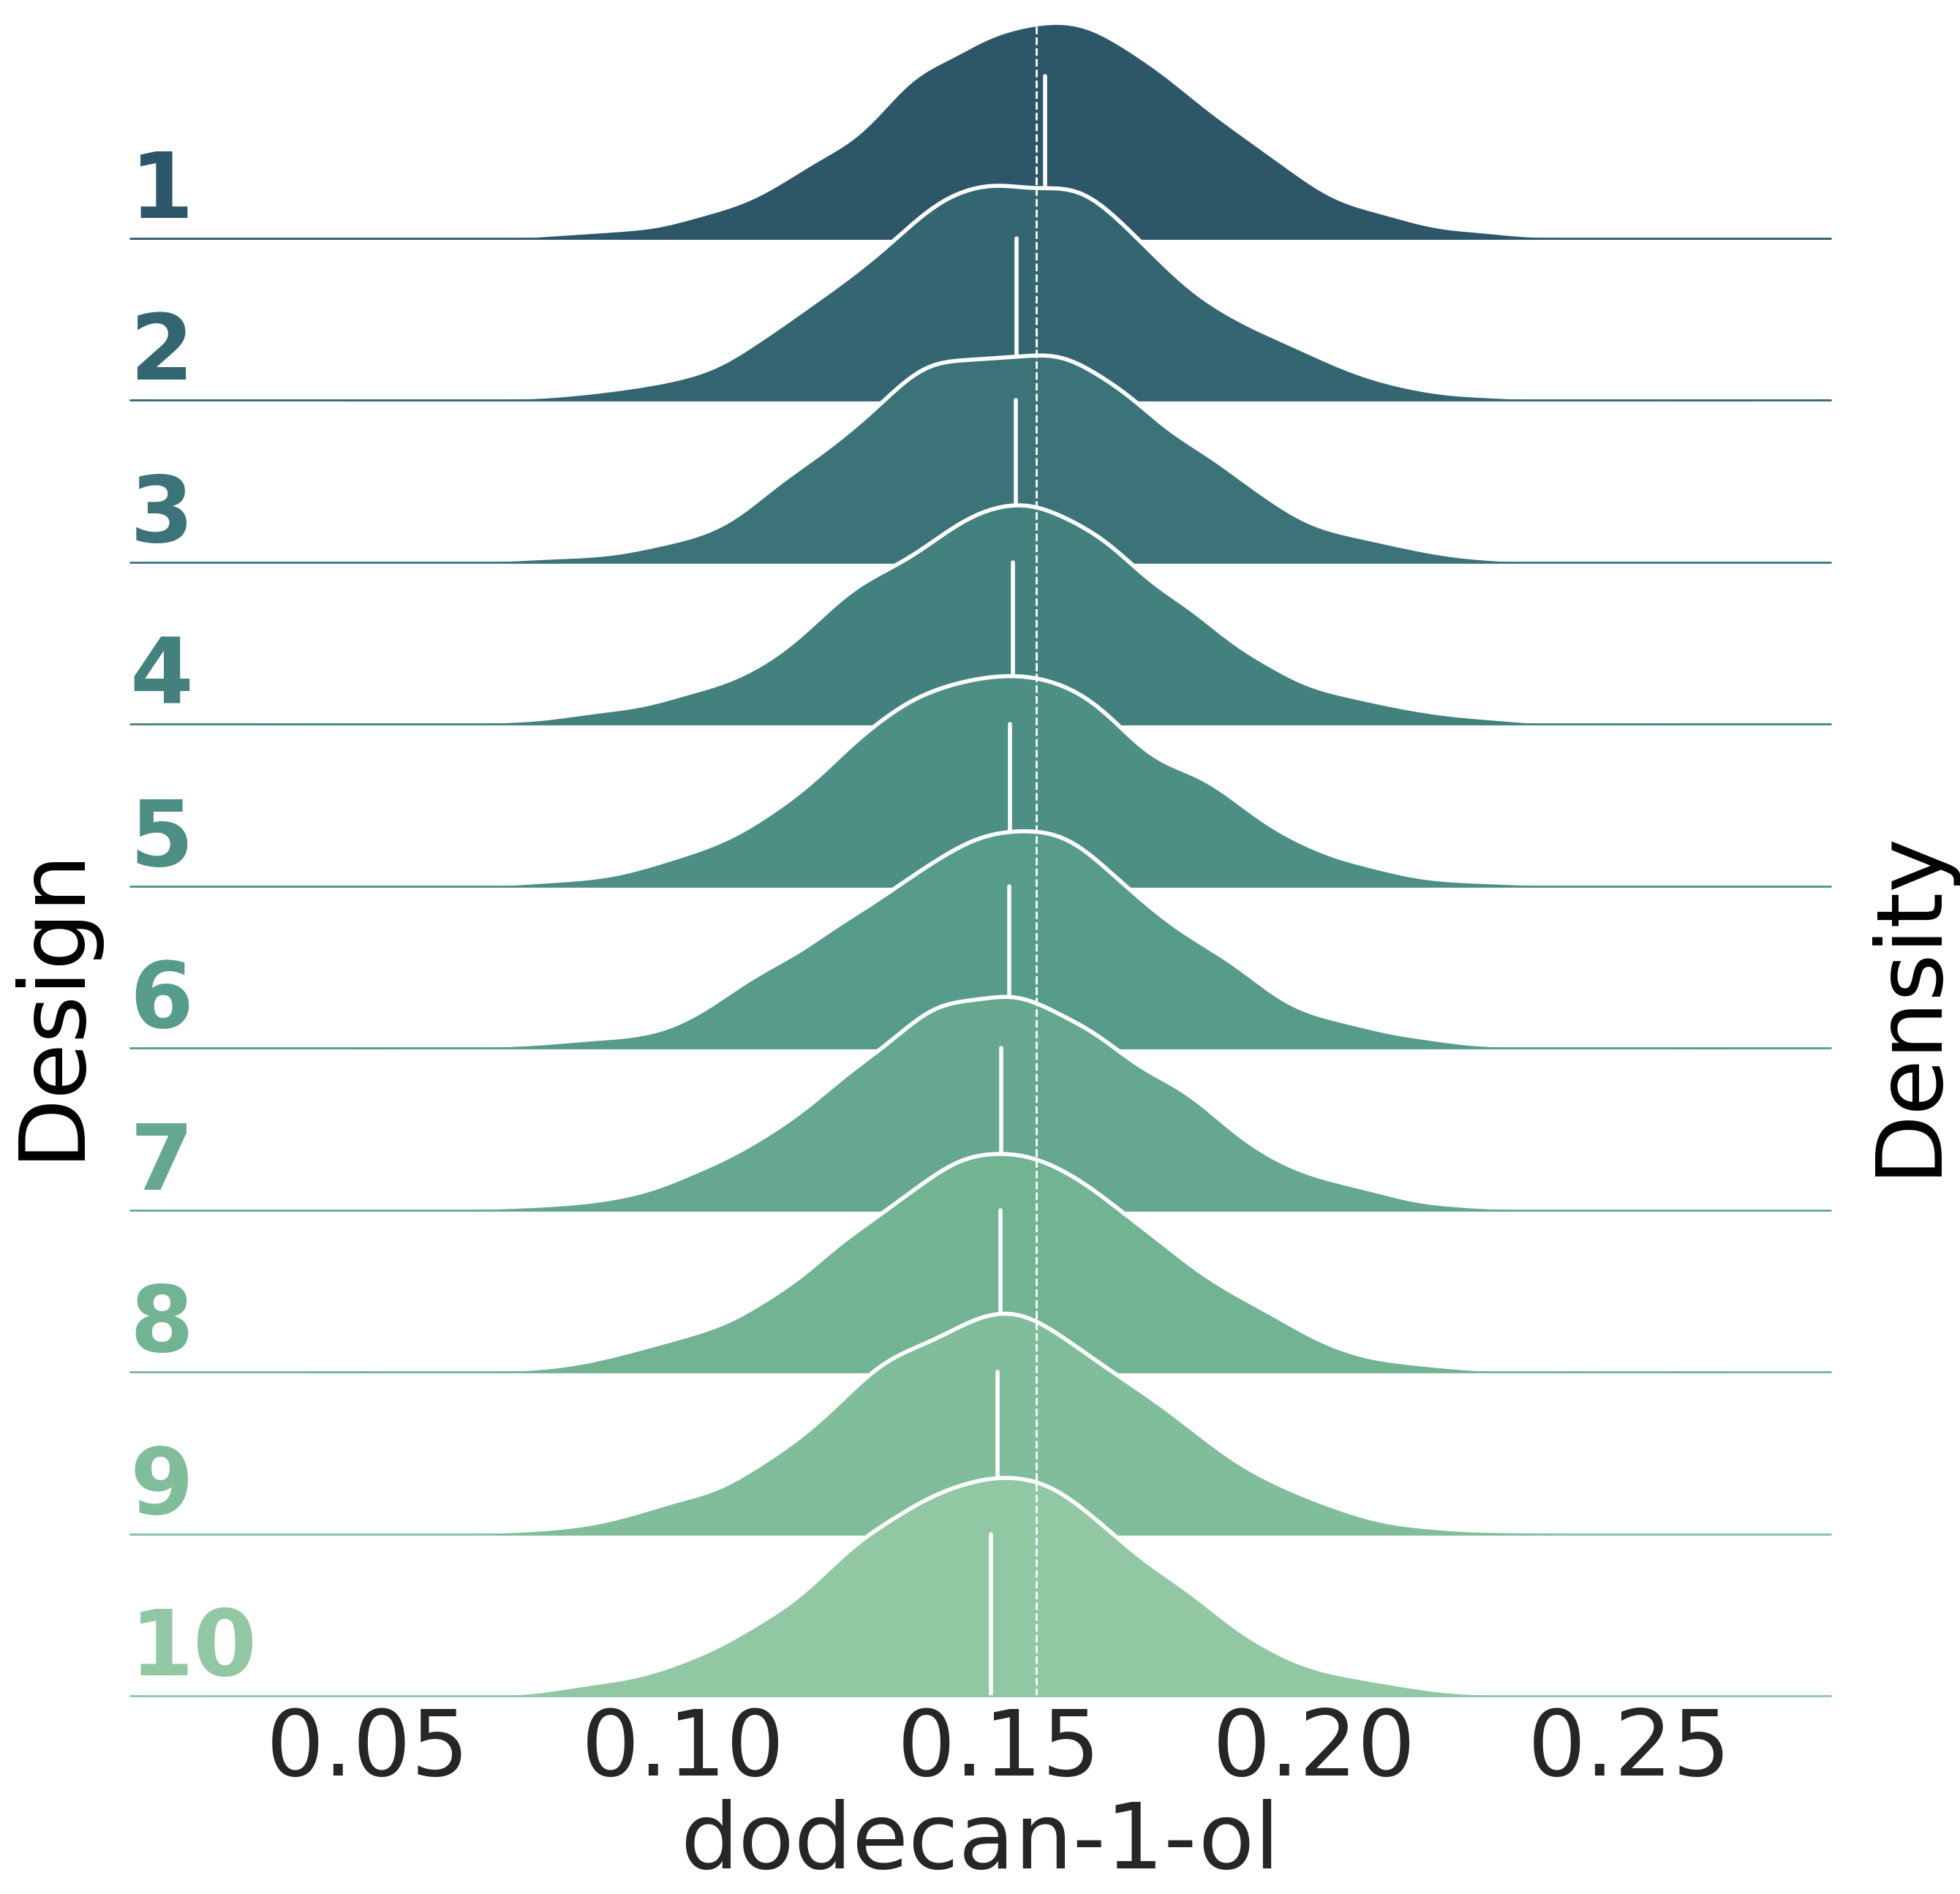

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.72 s
Done computing success probabilities in 0.72 s


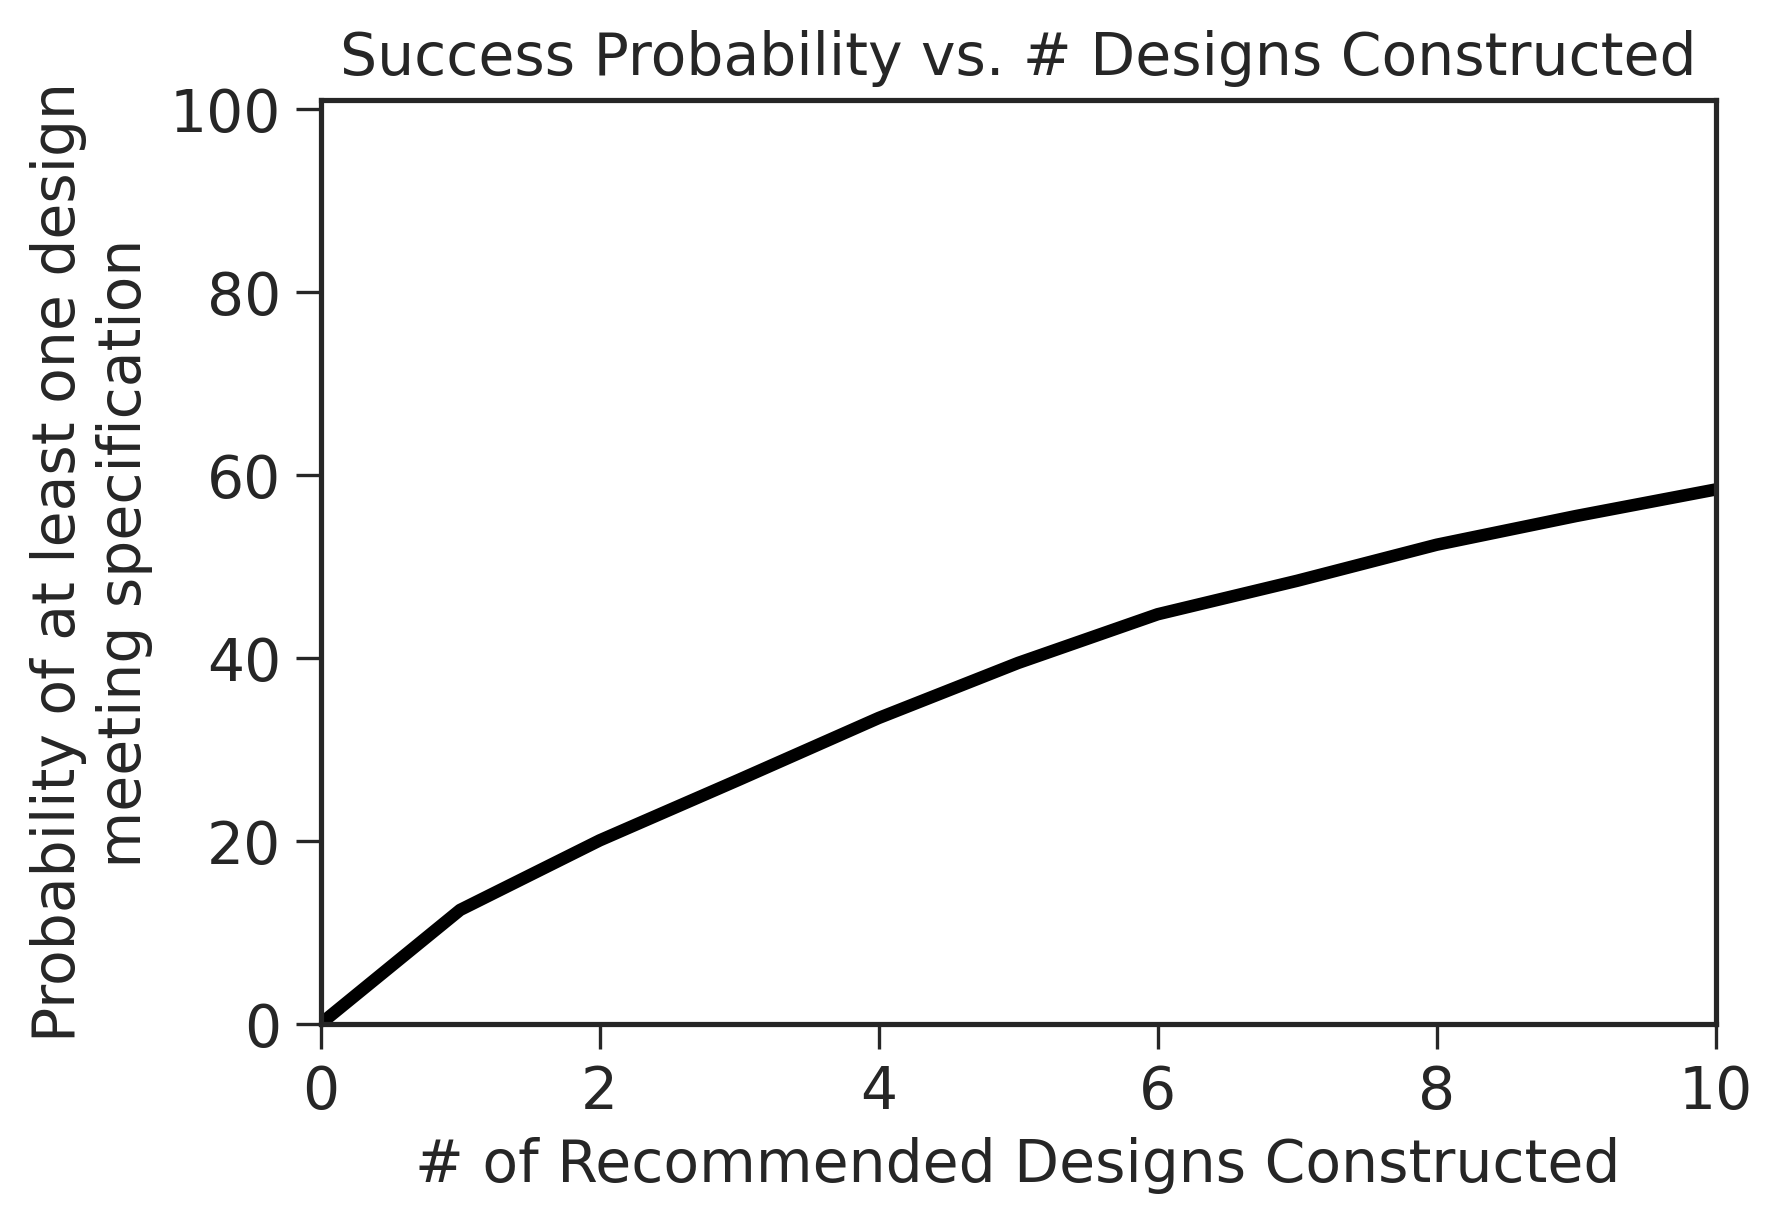

In [35]:
art_C2.select_recommendations(draws_2)

Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.71 s


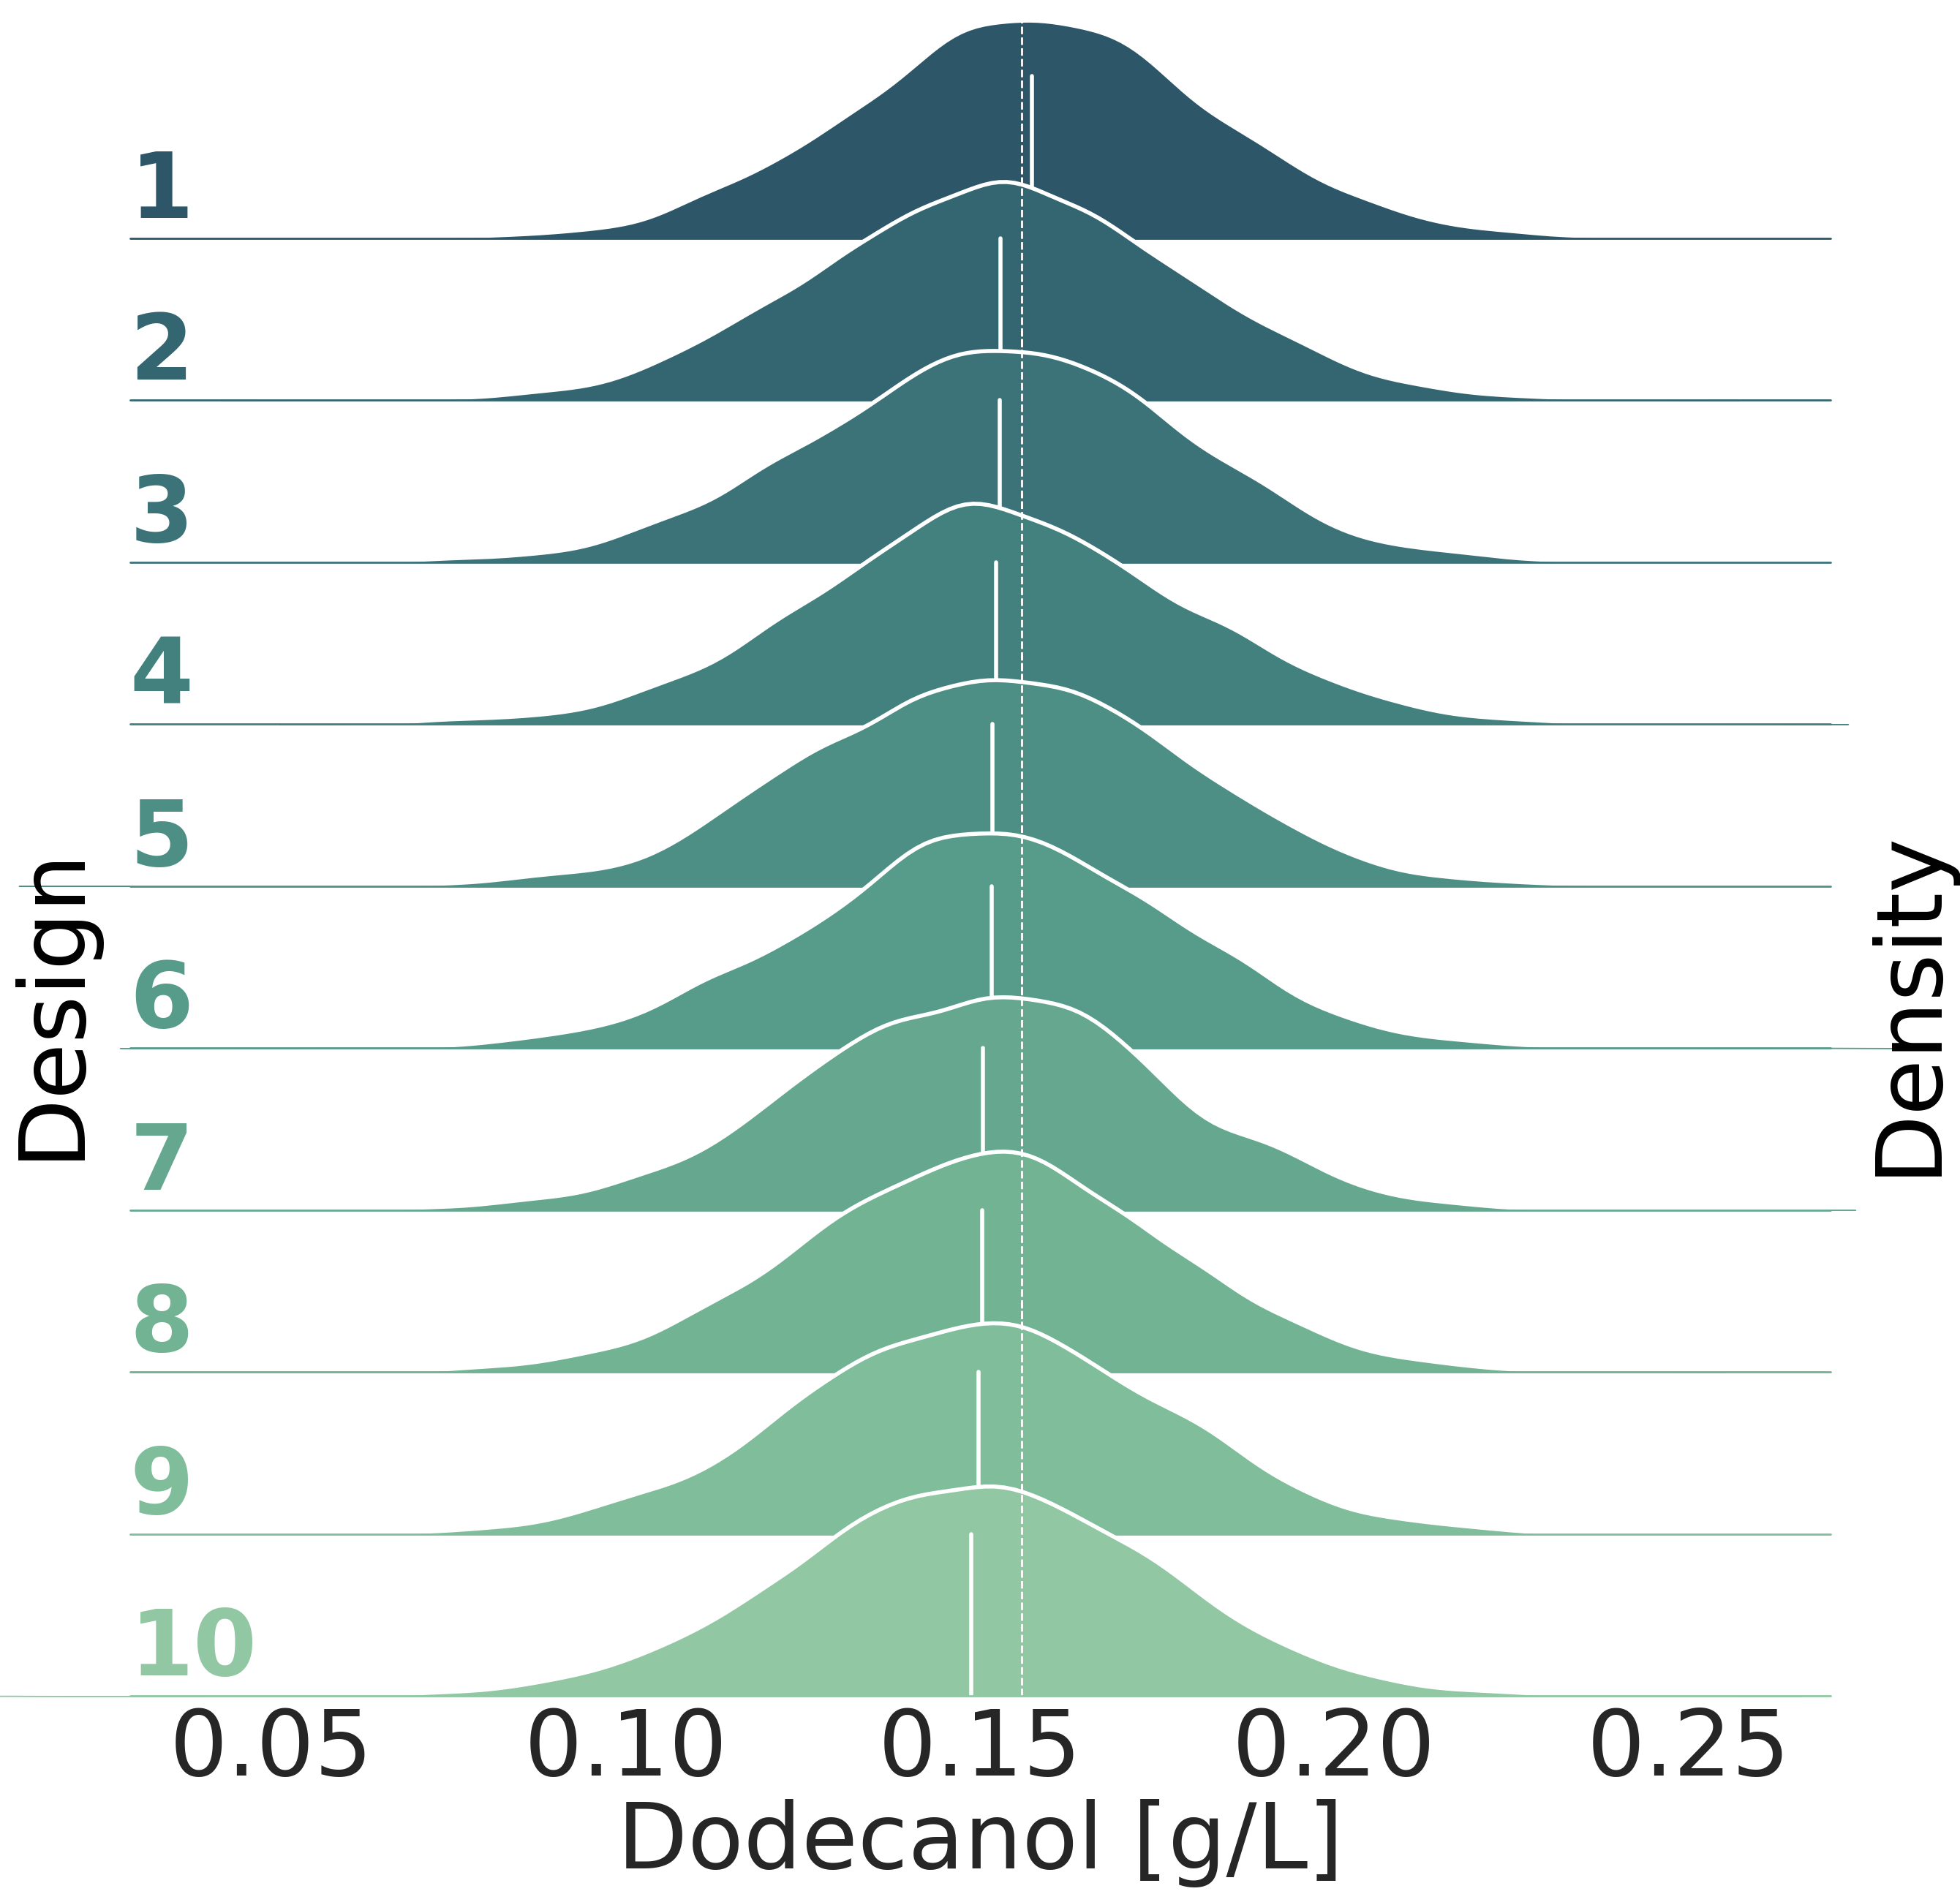

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.71 s
Done computing success probabilities in 0.71 s


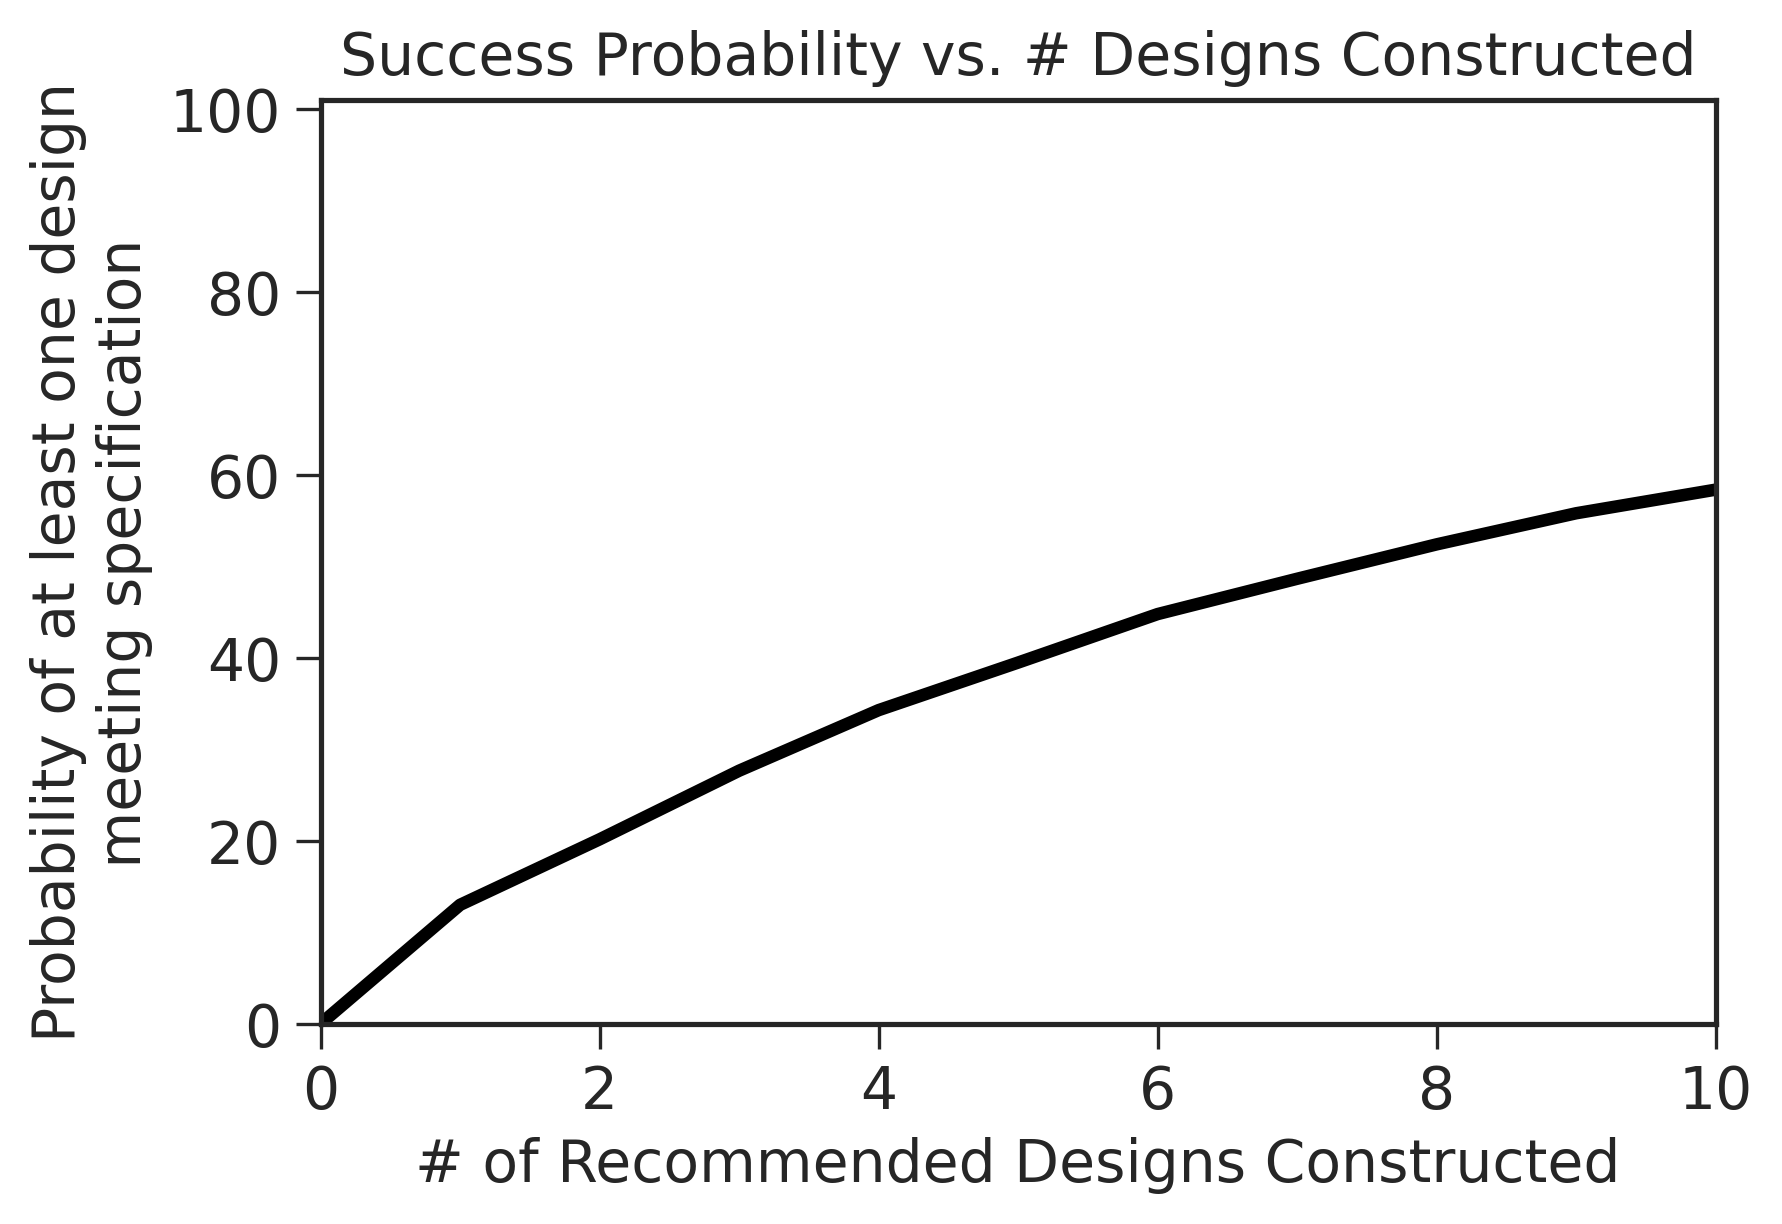

In [36]:
plot.recomm_distribution(art_C2, ['Dodecanol [g/L]'],[0.03,0.27])
cum_success_prob = art_C2.compute_success_prob(current_best=art_C2.find_current_best())
plot.success_prob(art_C2, cum_success_prob)

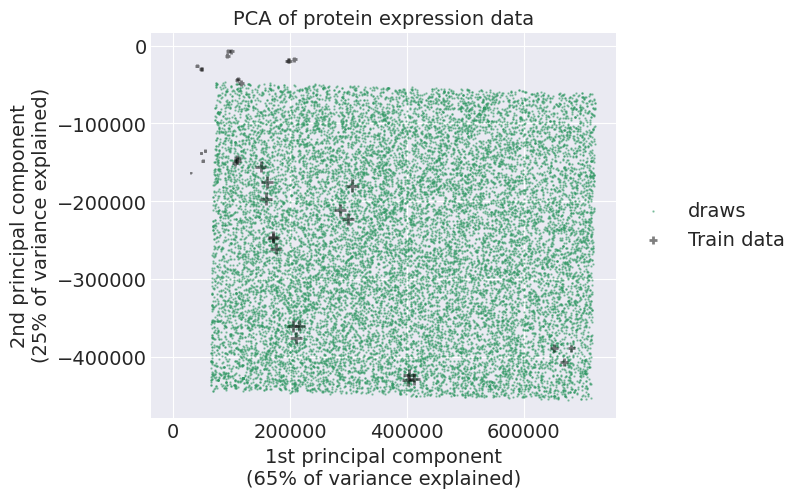

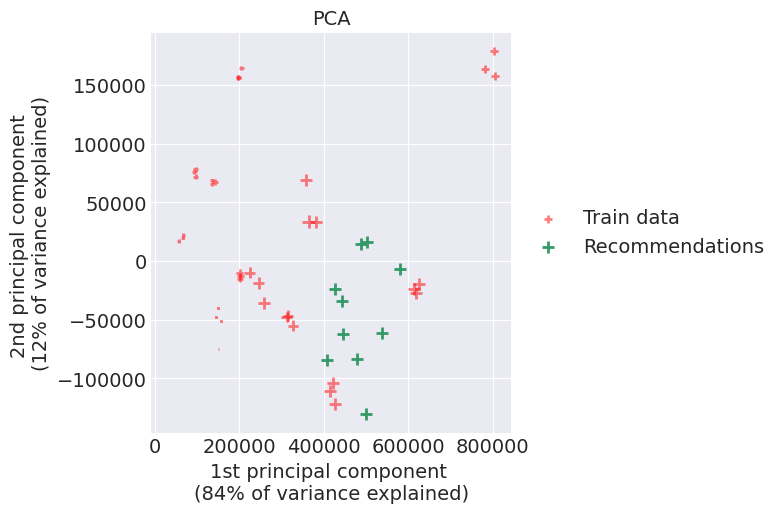

In [37]:
plot.draws_pc(art_C2, draws_2, plot_scale_factor=500, plot_draws=True, plot_kde=False)
plot.recommendations_pc(art_C2, plot_scale_factor=500)

In [38]:
art_C2.save()